___
# Patient Trajectory Clustering with Contrastive Learning
## **Introduction and Project Overview**  
- **Objectives:** Cluster patient trajectories using contrastive learning  
- **Data Source:** MIMIC-IV clinical data (ICU patients)  
- **Expected Outcomes:** Evaluation criteria and clinical insights

## What is “Patient Trajectory Clustering with Contrastive Learning”?

- Imagine you’re a doctor with thousands of ICU patients, each with a timeline of events: vitals (like heart rate, blood pressure), lab tests, and maybe a diagnosis.
You want to group similar patients together, based on how their health progressed in the ICU — even if you don’t know what their final outcome was.
This is what trajectory clustering does: It finds groups of patients whose medical histories look similar over time.
- But wait — each patient has lots of time-stamped data. How do you compare them? 
That’s where contrastive learning comes in.
__



### Step-by-step:
- Extract patient timelines from MIMIC-IV (like vitals over time).

- Create different views of each patient's timeline (random masking, jittering).

- Train a model using contrastive learning to create patient embeddings (a kind of summary).

- Use clustering (like KMeans) on the embeddings to group patients.

- Use charts and plots (like t-SNE, cluster profiles, vitals over time) to explain and compare the groups.





___
# Section 1: Data Loading, Preprocessing & Feature Engineering
- Loads raw data files (patients, admissions, icustays, etc.).
- Performs cleaning (type conversion, missing value handling) and creates new features (e.g., alive/died flags, winsorized LOS).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from tqdm import tqdm  # For progress bar

import glob
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Set Global Parameters

In [2]:
LIMIT_CHARTEVENTS = 2**26
chunksize = LIMIT_CHARTEVENTS/(2**1)

TREND_DURATION = 36

NUM_CLUSTERS = 4
PCA_COMPONENTS=512
NUM_EPOCHS=20

#GROUP_FEATURES = False  # or True
GROUP_FEATURES = True
feature_col_name = 'group_rep' if GROUP_FEATURES else 'feature'

# Set seaborn theme
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
# Set the path to your MIMIC-IV CSVs
DATA_PATH = '../data/'

#### Inspect table Function

In [3]:
def inspect_table(df, table_name="DataFrame", head="yes", summary="yes", plot="yes"):
    """
    Inspects a DataFrame by optionally printing the first few rows, a summary of null and non-null counts,
    and plotting a horizontal stacked bar chart of the counts.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to inspect.
    table_name (str): A label for the DataFrame (default "DataFrame").
    head (str): If "yes", display the first 5 rows. Otherwise, skip (default "yes").
    summary (str): If "yes", display the summary (null and non-null counts). Otherwise, skip (default "yes").
    plot (str): If "yes", plot the horizontal bar chart of null and non-null counts. Otherwise, skip (default "yes").
    """
    print(f"--- Inspecting {table_name} ---")
    print(f"Shape (rows, columns): {df.shape}\n")
    
    # Optionally display the first 5 rows
    if head.lower() == "yes":
        print("First 5 Rows:")
        display(df.head())
        print()
    
    # Compute non-null and null counts for each column
    non_null_counts = df.notnull().sum()
    null_counts = df.isnull().sum()
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Non-Null Count': non_null_counts,
        'Null Count': null_counts
    })
    
    # Optionally display the summary
    if summary.lower() == "yes":
        print("Null and Non-Null Counts per Column:")
        display(summary_df)
        print()
    
    # Optionally plot the summary as a horizontal stacked bar chart
    if plot.lower() == "yes":
        ax = summary_df.plot(kind='barh', stacked=True, figsize=(8, 4), 
                              title=f"Non-Null and Null Counts for {table_name}")
        ax.set_xlabel("Count")
        ax.set_ylabel("Columns")
        plt.tight_layout()
        plt.show()

#### Load `patients.csv`
- Preprocess the data
- Preview the data
- Gender and Age Distribution

- **Data Loading & Initial Inspection:**
  - Load patients data from CSV using `pd.read_csv()`.
  - Inspect the table with `inspect_table()`.
  - Display gender counts.
  - Select only `subject_id`, `gender`, `anchor_age`, and `dod` columns.

- **Feature Engineering & Data Cleaning:**
  - Create `alive` column (True if `dod` is null) and `died` column (1 if `dod` exists).
  - Rename `dod` to `date_of_death`.
  - Convert `date_of_death` to datetime; convert `subject_id` and `anchor_age` to numeric.
  - Standardize `gender` values to uppercase.
  - Drop duplicate rows.
  - Count and print duplicate `subject_id`s.
  - Re-inspect the cleaned table with `inspect_table()`.

- **Visualization Preparation & Plotting:**
  - Compute gender counts and define labels.
  - Set custom colors and explode values for the pie chart.
  - Create subplots for pie chart (gender distribution) and histogram (age distribution).
  - Plot pie chart with percentage labels, starting angle, and shadow.
  - Plot histogram with 15 bins and appropriate axis labels.
  - Adjust layout with `plt.tight_layout()` and display the plots.

--- Inspecting Patients Table after Loading ---
Shape (rows, columns): (364627, 6)

First 5 Rows:


subject_id gender  anchor_age  anchor_year anchor_year_group         dod
0    10000032      F          52         2180       2014 - 2016  2180-09-09
1    10000048      F          23         2126       2008 - 2010         NaN
2    10000058      F          33         2168       2020 - 2022         NaN
3    10000068      F          19         2160       2008 - 2010         NaN
4    10000084      M          72         2160       2017 - 2019  2161-02-13


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                 364627           0
gender                     364627           0
anchor_age                 364627           0
anchor_year                364627           0
anchor_year_group          364627           0
dod                         38301      326326

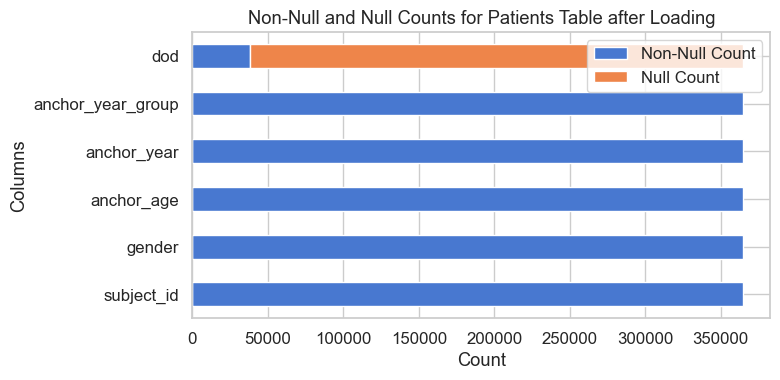

Number of duplicate subject_ids: 0
--- Inspecting Patients Table after Cleanup ---
Shape (rows, columns): (364627, 6)

First 5 Rows:


subject_id gender  anchor_age date_of_death  alive  died
0    10000032      F          52    2180-09-09  False     1
1    10000048      F          23           NaT   True     0
2    10000058      F          33           NaT   True     0
3    10000068      F          19           NaT   True     0
4    10000084      M          72    2161-02-13  False     1


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id             364627           0
gender                 364627           0
anchor_age             364627           0
date_of_death           38301      326326
alive                  364627           0
died                   364627           0

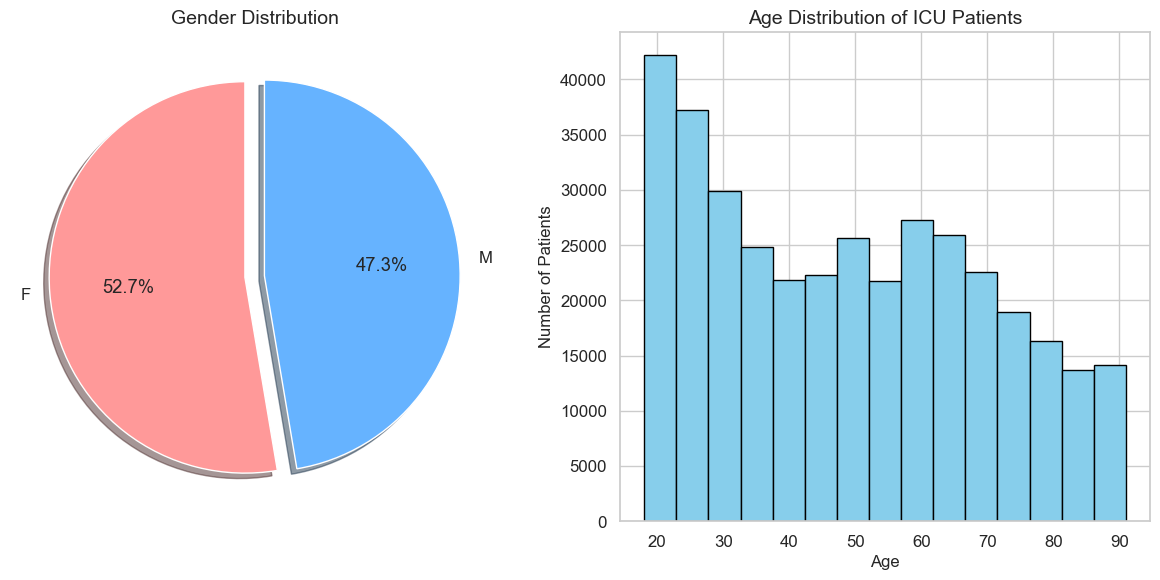

In [4]:
patients = pd.read_csv(DATA_PATH + 'patients.csv')
inspect_table(patients, "Patients Table after Loading")
patients['gender'].value_counts()
patients = patients[['subject_id', 'gender', 'anchor_age', 'dod']]

patients['alive'] = patients['dod'].isnull()
patients['died'] = patients['dod'].notna().astype(int)
patients.rename(columns={'dod': 'date_of_death'}, inplace=True)

patients['date_of_death'] = pd.to_datetime(patients['date_of_death'], errors='coerce')
patients['subject_id'] = pd.to_numeric(patients['subject_id'], errors='coerce')
patients['anchor_age'] = pd.to_numeric(patients['anchor_age'], errors='coerce')

patients['gender'] = patients['gender'].str.upper()

# Drop duplicates in the admissions DataFrame
patients.drop_duplicates(inplace=True)

duplicate_subject_ids = patients['subject_id'].duplicated().sum()
print(f"Number of duplicate subject_ids: {duplicate_subject_ids}")

inspect_table(patients, "Patients Table after Cleanup", head="yes", summary="yes", plot="no")

# Prepare data for the pie chart
gender_counts = patients['gender'].value_counts()
gender_labels = gender_counts.index
colors = ['#ff9999', '#66b3ff']  # Customize colors for male and female
explode = (0.05, 0.05)  # Slightly separate each slice for emphasis

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for gender distribution
axes[0].pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', startangle=90, 
            colors=colors, explode=explode, shadow=True)
axes[0].set_title("Gender Distribution", fontsize=14)

# Age distribution histogram
axes[1].hist(patients['anchor_age'], bins=15, color='skyblue', edgecolor='black')
axes[1].set_title("Age Distribution of ICU Patients", fontsize=14)
axes[1].set_xlabel("Age", fontsize=12)
axes[1].set_ylabel("Number of Patients", fontsize=12)

plt.tight_layout()
plt.show()

#### Load `admissions.csv`
- Preprocess the data
- Preview the data
- Show Charts : Count of 
    - Admission Type
    - Marital Status
    - Race

- **Data Loading & Initial Inspection:**
  - Load the admissions dataset from CSV.
  - Inspect the table using `inspect_table()` to view initial data.

- **Grouping Top Categories Function:**
  - Define `group_top_categories()` to retain only the top 4 categories.
  - Label all other categories as "Other".

- **Apply Grouping Function:**
  - Apply the function to `admission_type`, `marital_status`, and `race` columns.
  - Create grouped series for each categorical column.

- **Compute Sorted Counts:**
  - Calculate and sort value counts for each grouped category in descending order.

- **Visualization with Bar Charts:**
  - Create a figure with three subplots for the bar charts.
  - **Chart 1:** Bar chart for Admission Type.
  - **Chart 2:** Bar chart for Marital Status.
  - **Chart 3:** Bar chart for Race.
  - Customize charts with titles, axis labels, and rotated x-axis labels.
  - Use Seaborn's `barplot` with the `Set2` palette.

- **Layout Adjustment & Display:**
  - Adjust layout using `plt.tight_layout()`.
  - Render the plots with `plt.show()`.

- **Data Cleanup for Trajectory Analysis:**
  - Drop unneeded columns from the admissions DataFrame.
  - Convert time columns (`admittime`, `dischtime`, `deathtime`) to datetime format.

- **Creating Mortality Flag:**
  - Generate `died_in_hospital` flag using `deathtime` or `hospital_expire_flag`.

- **Data Consistency Check:**
  - Filter out records where discharge time is earlier than admission time.
  - Inspect the cleaned table with `inspect_table()` to verify changes.


--- Inspecting Admissions Table after Loading ---
Shape (rows, columns): (546028, 16)

First 5 Rows:


subject_id   hadm_id            admittime            dischtime deathtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   
3    10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00       NaN   
4    10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00       NaN   

   admission_type admit_provider_id      admission_location  \
0          URGENT            P49AFC  TRANSFER FROM HOSPITAL   
1        EW EMER.            P784FA          EMERGENCY ROOM   
2        EW EMER.            P19UTS          EMERGENCY ROOM   
3        EW EMER.            P06OTX          EMERGENCY ROOM   
4  EU OBSERVATION            P39NWO          EMERGENCY ROOM   

  discharge_location insurance language marital_status   race  \
0               HOME  Medicaid  English        WIDOWED  WHITE   
1               HOME  Medicaid  English        WIDOWED  WHITE   
2            HOSPICE  Medicaid  English        WIDOWED  WHITE   
3               HOME  Medicaid  English        WIDOWED  WHITE   
4                NaN       NaN  English         SINGLE  WHITE   

             edregtime            edouttime  hospital_expire_flag  
0  2180-05-06 19:17:00  2180-05-06 23:30:00                     0  
1  2180-06-26 15:54:00  2180-06-26 21:31:00                     0  
2  2180-08-05 20:58:00  2180-08-06 01:44:00                     0  
3  2180-07-23 05:54:00  2180-07-23 14:00:00                     0  
4  2160-03-03 21:55:00  2160-03-04 06:26:00                     0


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                    546028           0
hadm_id                       546028           0
admittime                     546028           0
dischtime                     546028           0
deathtime                      11790      534238
admission_type                546028           0
admit_provider_id             546024           4
admission_location            546027           1
discharge_location            396210      149818
insurance                     536673        9355
language                      545253         775
marital_status                532409       13619
race                          546028           0
edregtime                     379240      166788
edouttime                     379240      166788
hospital_expire_flag          546028           0

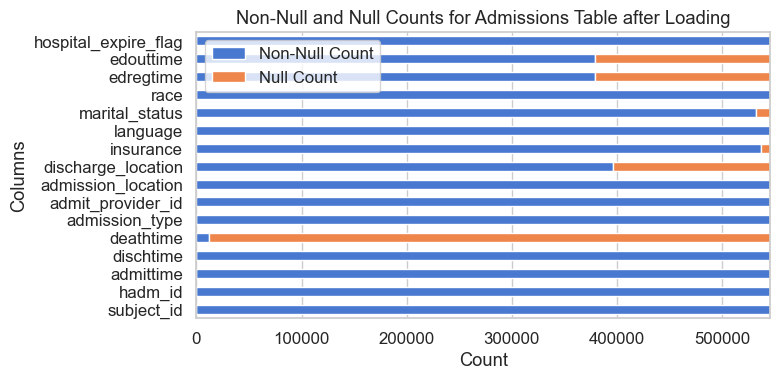

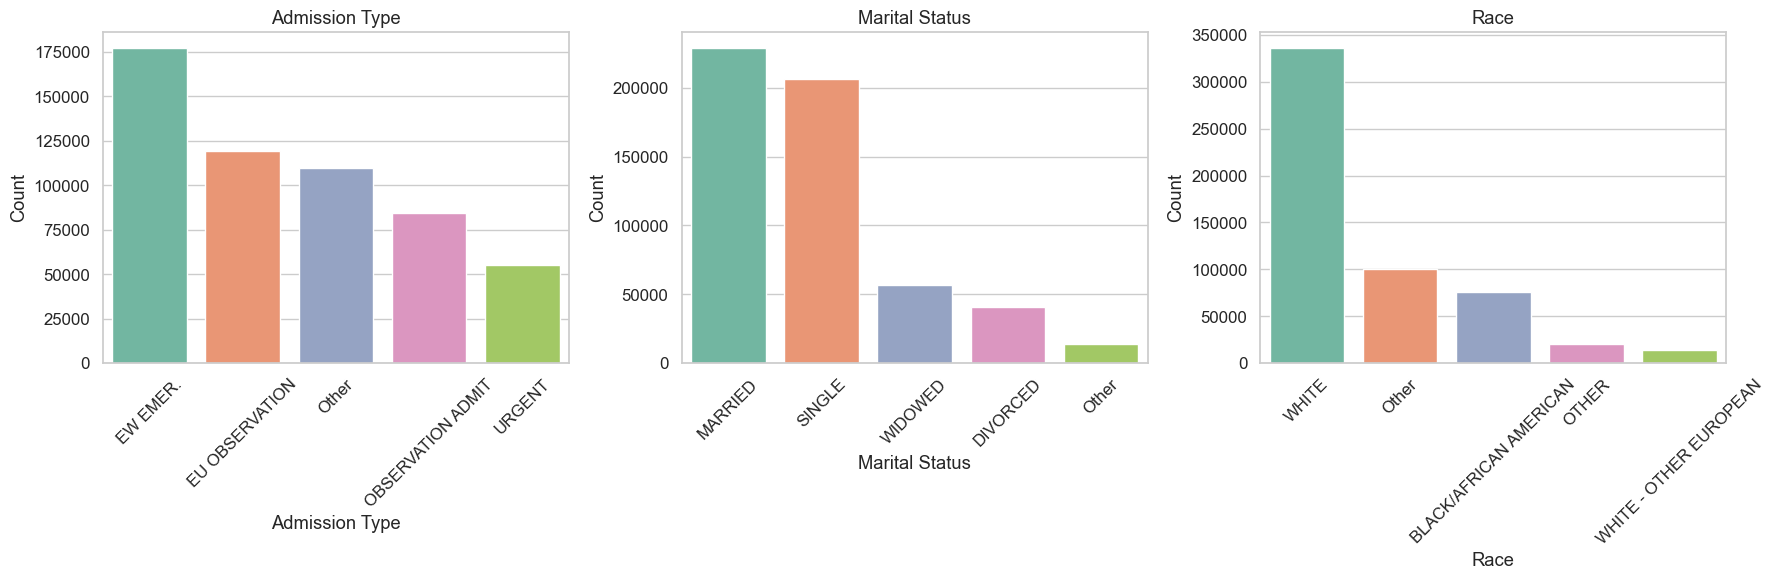

--- Inspecting Admissions Table after Cleanup ---
Shape (rows, columns): (545853, 9)

First 5 Rows:


subject_id   hadm_id           admittime           dischtime deathtime  \
0    10000032  22595853 2180-05-06 22:23:00 2180-05-07 17:15:00       NaT   
1    10000032  22841357 2180-06-26 18:27:00 2180-06-27 18:49:00       NaT   
2    10000032  25742920 2180-08-05 23:44:00 2180-08-07 17:50:00       NaT   
3    10000032  29079034 2180-07-23 12:35:00 2180-07-25 17:55:00       NaT   
4    10000068  25022803 2160-03-03 23:16:00 2160-03-04 06:26:00       NaT   

   admission_type   race  hospital_expire_flag  died_in_hospital  
0          URGENT  WHITE                     0             False  
1        EW EMER.  WHITE                     0             False  
2        EW EMER.  WHITE                     0             False  
3        EW EMER.  WHITE                     0             False  
4  EU OBSERVATION  WHITE                     0             False


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                    545853           0
hadm_id                       545853           0
admittime                     545853           0
dischtime                     545853           0
deathtime                      11689      534164
admission_type                545853           0
race                          545853           0
hospital_expire_flag          545853           0
died_in_hospital              545853           0

In [5]:
admissions = pd.read_csv(DATA_PATH + 'admissions.csv')
inspect_table(admissions, "Admissions Table after Loading")

# Function to group and re-label a Series so that only the top 4 categories remain,
# and all others are labeled as "Other".
def group_top_categories(series, top_n=4):
    counts = series.value_counts()
    top_categories = counts.index[:top_n]
    return series.apply(lambda x: x if x in top_categories else 'Other')


# Re-label the columns in the admissions DataFrame
admission_type_grouped = group_top_categories(admissions['admission_type'])
marital_status_grouped = group_top_categories(admissions['marital_status'])
race_grouped = group_top_categories(admissions['race'])

# Compute sorted counts (from highest to lowest)
counts_admission_type = admission_type_grouped.value_counts().sort_values(ascending=False)
counts_marital_status = marital_status_grouped.value_counts().sort_values(ascending=False)
counts_race = race_grouped.value_counts().sort_values(ascending=False)

# Create a figure with three vertical bar charts side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Chart 1: Admission Type
sns.barplot(x=counts_admission_type.index, hue=counts_admission_type.index, y=counts_admission_type.values, ax=axes[0], palette='Set2')
axes[0].set_title("Admission Type")
axes[0].set_xlabel("Admission Type")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Chart 2: Marital Status
sns.barplot(x=counts_marital_status.index, hue=counts_marital_status.index, y=counts_marital_status.values, ax=axes[1], palette='Set2')
axes[1].set_title("Marital Status")
axes[1].set_xlabel("Marital Status")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

# Chart 3: Race
sns.barplot(x=counts_race.index, hue=counts_race.index, y=counts_race.values, ax=axes[2], palette='Set2')
axes[2].set_title("Race")
axes[2].set_xlabel("Race")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Drop columns that are not needed for the trajectory analysis
columns_to_drop = [
    'admit_provider_id', 'admission_location', 'discharge_location',
    'insurance', 'language', 'marital_status', 'edregtime', 'edouttime'
]
admissions.drop(columns=columns_to_drop, inplace=True)

# Convert time columns to datetime
admissions['admittime'] = pd.to_datetime(admissions['admittime'], errors='coerce')
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'], errors='coerce')
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'], errors='coerce')

# Optionally, create a mortality flag using the deathtime or hospital_expire_flag
admissions['died_in_hospital'] = admissions['deathtime'].notnull() | (admissions['hospital_expire_flag'] == 1)

# Verify that admission happens before discharge
admissions = admissions[admissions['dischtime'] >= admissions['admittime']]
inspect_table(admissions, "Admissions Table after Cleanup", head="yes", summary="yes", plot="no")

#### Load `icustays.csv`
- Preprocess the data
- Preview the data
- Show Charts
    - Length of Stay - Bar Chart
    - Box Plot Chart - Length of Stay

- **Data Loading & Inspection:**
  - Load ICU stays data from CSV using `pd.read_csv()`.
  - Inspect the table with `inspect_table()`.

- **Define Binning Parameters:**
  - Set bin edges (in hours) for ICU length of stay.
  - Define corresponding bin labels for each interval.

- **Binning the Data:**
  - Use `pd.cut()` to categorize the `los` column based on defined bin edges and labels.
  - Use `right=False` to make bins left-inclusive.

- **Counting & Sorting:**
  - Compute bin counts with `value_counts()` and sort them by index.

- **Visualization:**
  - Create a figure with specified dimensions.
  - Plot a vertical bar chart using Seaborn's `barplot` with the bin counts.
  - Set chart title, axis labels, and rotate x-tick labels for clarity.
  - Adjust layout with `plt.tight_layout()` and display the plot with `plt.show()`.


--- Inspecting ICU Stays Table after Loading ---
Shape (rows, columns): (94458, 8)

First 5 Rows:


subject_id   hadm_id   stay_id                       first_careunit  \
0    10000032  29079034  39553978   Medical Intensive Care Unit (MICU)   
1    10000690  25860671  37081114   Medical Intensive Care Unit (MICU)   
2    10000980  26913865  39765666   Medical Intensive Care Unit (MICU)   
3    10001217  24597018  37067082  Surgical Intensive Care Unit (SICU)   
4    10001217  27703517  34592300  Surgical Intensive Care Unit (SICU)   

                         last_careunit               intime  \
0   Medical Intensive Care Unit (MICU)  2180-07-23 14:00:00   
1   Medical Intensive Care Unit (MICU)  2150-11-02 19:37:00   
2   Medical Intensive Care Unit (MICU)  2189-06-27 08:42:00   
3  Surgical Intensive Care Unit (SICU)  2157-11-20 19:18:02   
4  Surgical Intensive Care Unit (SICU)  2157-12-19 15:42:24   

               outtime       los  
0  2180-07-23 23:50:47  0.410266  
1  2150-11-06 17:03:17  3.893252  
2  2189-06-27 20:38:27  0.497535  
3  2157-11-21 22:08:00  1.118032  
4  2157-12-20 14:27:41  0.948113


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id               94458           0
hadm_id                  94458           0
stay_id                  94458           0
first_careunit           94458           0
last_careunit            94458           0
intime                   94458           0
outtime                  94444          14
los                      94444          14

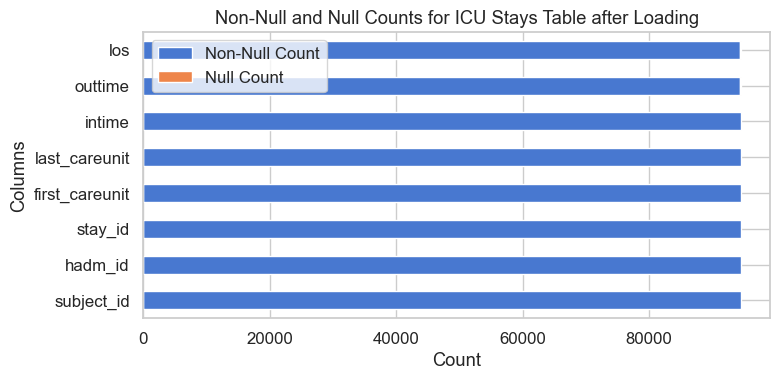

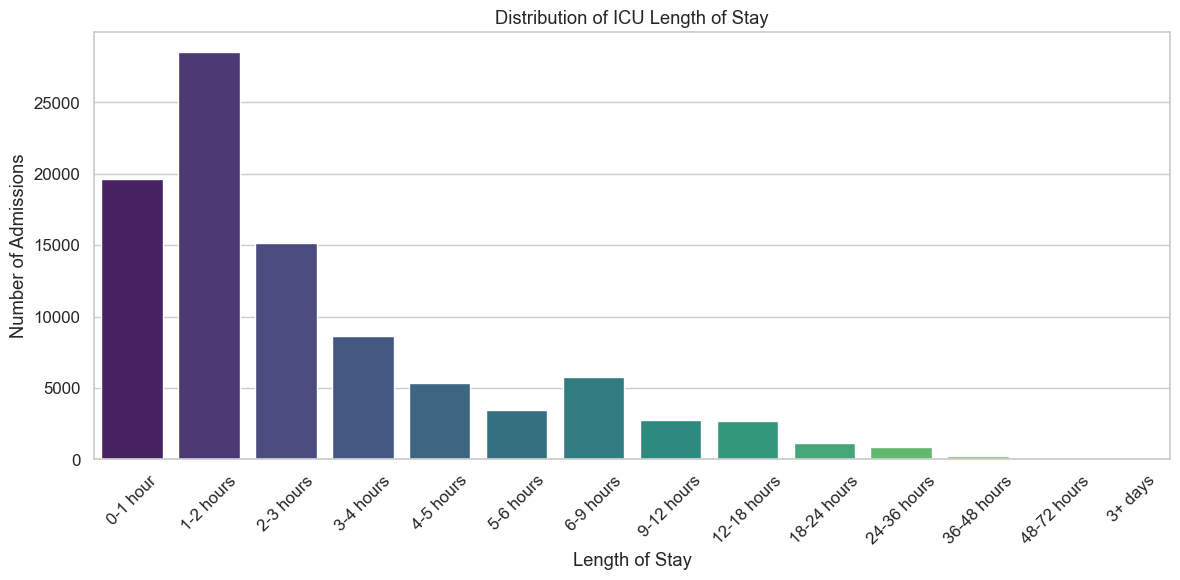

In [6]:
icustays = pd.read_csv(DATA_PATH + 'icustays.csv')
inspect_table(icustays, "ICU Stays Table after Loading")

#  bin edges as specified (in hours)
bin_edges = [0, 1, 2, 3, 4, 5, 6, 9, 12, 18, 24, 36, 48, 72, np.inf]

# Corresponding bin labels
bin_labels = [
    '0-1 hour',
    '1-2 hours',
    '2-3 hours',
    '3-4 hours',
    '4-5 hours',
    '5-6 hours',
    '6-9 hours',
    '9-12 hours',
    '12-18 hours',
    '18-24 hours',
    '24-36 hours',
    '36-48 hours',
    '48-72 hours',
    '3+ days'
]

# Bin the ICU length of stay data (assuming the 'los' column is in hours)
los_bins = pd.cut(icustays['los'], bins=bin_edges, labels=bin_labels, right=False)

# Count the number of ICU stays in each bin
bin_counts = los_bins.value_counts().sort_index()

# Plot the results as a vertical bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=bin_counts.index, hue=bin_counts.index, y=bin_counts.values, palette='viridis')
plt.title("Distribution of ICU Length of Stay")
plt.xlabel("Length of Stay")
plt.ylabel("Number of Admissions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- **Convert Time Columns:**
  - Convert `intime` and `outtime` to datetime format with error coercion.
- **Filter Valid ICU Stays:**
  - Retain only rows where `outtime` is greater than or equal to `intime`.
- **Calculate ICU Length of Stay:**
  - Compute `icu_los_hours` by calculating the time difference (in hours) between `outtime` and `intime`.
- **Statistical Summary:**
  - Calculate and print median, Q1 (25th percentile), and Q3 (75th percentile) of `icu_los_hours`.
- **Boxplot Visualization:**
  - Drop missing values from `icu_los_hours` to compute min and max.
  - Create a horizontal boxplot for ICU LOS.
  - Annotate the plot with min (green) and max (red) values.
- **Data Cleanup:**
  - Drop unnecessary columns, retaining only `subject_id`, `hadm_id`, `stay_id`, `intime`, `outtime`, and `icu_los_hours`.
  - Remove duplicate rows.
  - Inspect the cleaned ICU stays table.
- **Extract Top and Bottom Records:**
  - Sort the DataFrame to obtain the bottom 10 ICU stays (shortest LOS).
  - Sort in descending order to obtain the top 10 ICU stays (longest LOS).
  - Print details for both bottom 10 and top 10 records.

Median Length of Stay Calculated: 47.175555555555555
25th Percentile (Q1) Length of Stay Calculated:: 26.30909722222222
75th Percentile (Q3) Length of Stay Calculated:: 92.70180555555555


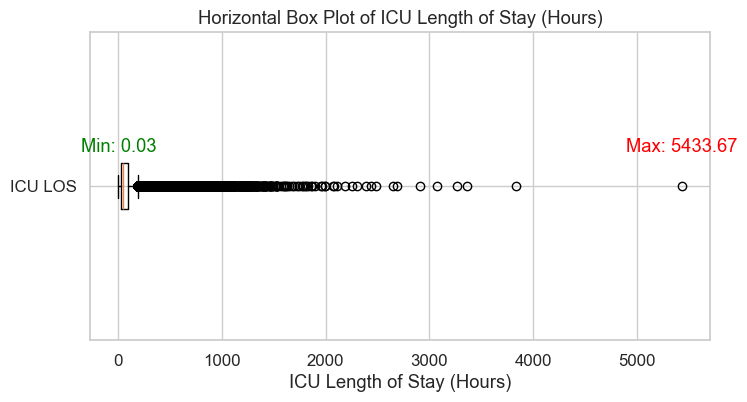

--- Inspecting ICU Stays Table after Cleanup ---
Shape (rows, columns): (94444, 6)

First 5 Rows:


subject_id   hadm_id   stay_id              intime             outtime  \
0    10000032  29079034  39553978 2180-07-23 14:00:00 2180-07-23 23:50:47   
1    10000690  25860671  37081114 2150-11-02 19:37:00 2150-11-06 17:03:17   
2    10000980  26913865  39765666 2189-06-27 08:42:00 2189-06-27 20:38:27   
3    10001217  24597018  37067082 2157-11-20 19:18:02 2157-11-21 22:08:00   
4    10001217  27703517  34592300 2157-12-19 15:42:24 2157-12-20 14:27:41   

   icu_los_hours  
0       9.846389  
1      93.438056  
2      11.940833  
3      26.832778  
4      22.754722


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id              94444           0
hadm_id                 94444           0
stay_id                 94444           0
intime                  94444           0
outtime                 94444           0
icu_los_hours           94444           0


Bottom 10 ICU Length of Stay:
       subject_id   hadm_id   stay_id  icu_los_hours
46580    14933260  26818445  39088393       0.030000
54263    15745117  23437079  30540914       0.034722
87068    19217064  29818700  35932220       0.054444
23397    12489419  27536984  37403432       0.058056
37250    13941452  27790400  33255415       0.069444
81714    18640950  21069371  35342080       0.080278
9056     10971284  22087634  33084533       0.083056
14624    11547638  20084622  30056018       0.084444
13410    11417989  21819818  37302156       0.106111
40992    14336761  28887145  34970448       0.118889

Top 10 ICU Length of Stay:
       subject_id   hadm_id   stay_id  icu_los_hours
58337    16175244  29850931  36032605    5433.673889
12618    11336222  24784126  36307509    3832.003333
82745    18744840  22329603  39510663    3361.288056
15467    11633737  26571961  30359303    3264.697778
80317    18503414  24012265  31492392    3068.838611
2286     10253349  26415640  35629939   

In [7]:
icustays['intime'] = pd.to_datetime(icustays['intime'], errors='coerce')
icustays['outtime'] = pd.to_datetime(icustays['outtime'], errors='coerce')
# Filter out any rows where discharge time is earlier than admission time
icustays = icustays[icustays['outtime'] >= icustays['intime']]
icustays['icu_los_hours'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 3600
# Calculate median, 25th percentile (Q1), and 75th percentile (Q3)
median_val = icustays['icu_los_hours'].median()
q1 = icustays['icu_los_hours'].quantile(0.25)
q3 = icustays['icu_los_hours'].quantile(0.75)

print("Median Length of Stay Calculated:", median_val)
print("25th Percentile (Q1) Length of Stay Calculated::", q1)
print("75th Percentile (Q3) Length of Stay Calculated::", q3)

# Drop missing values and compute min and max
icu_los = icustays['icu_los_hours'].dropna()
min_value = icu_los.min()
max_value = icu_los.max()

plt.figure(figsize=(8, 4))
plt.boxplot(icu_los, vert=False)
plt.title("Horizontal Box Plot of ICU Length of Stay (Hours)")
plt.xlabel("ICU Length of Stay (Hours)")
plt.yticks([1], ['ICU LOS'])

# Annotate the min and max values on the plot
plt.text(min_value, 1.1, f"Min: {min_value:.2f}", ha='center', va='bottom', color='green')
plt.text(max_value, 1.1, f"Max: {max_value:.2f}", ha='center', va='bottom', color='red')

plt.show()

# Specify columns that are not necessary for this analysis
columns_to_drop = [col for col in icustays.columns if col not in ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'icu_los_hours']]
icustays.drop(columns=columns_to_drop, inplace=True)

icustays.drop_duplicates(inplace=True)
inspect_table(icustays, "ICU Stays Table after Cleanup", head="yes", summary="yes", plot="no")

# Sort the DataFrame by icu_los_hours in ascending order for the bottom 10
bottom_10 = icustays.sort_values(by='icu_los_hours').head(10)

# Sort the DataFrame by icu_los_hours in descending order for the top 10
top_10 = icustays.sort_values(by='icu_los_hours', ascending=False).head(10)

print("Bottom 10 ICU Length of Stay:")
print(bottom_10[['subject_id', 'hadm_id', 'stay_id', 'icu_los_hours']])
print("\nTop 10 ICU Length of Stay:")
print(top_10[['subject_id', 'hadm_id', 'stay_id', 'icu_los_hours']])

___
# Section 2: Data Merging & Construction of Trajectories

- **Merge Operations:**
  - Merge `patients` with `admissions` on `subject_id` using an inner join.
  - Inspect the merged DataFrame (`patients_admissions`).
  - Merge `patients_admissions` with `icustays` on `subject_id` and `hadm_id` using an inner join.
  - Inspect the resulting `patient_trajectories` DataFrame.

- **ICU Stay Analysis:**
  - Group `patient_trajectories` by `subject_id` and count ICU stays per patient.
  - Filter to retain only patients with more than one ICU stay.
  - Calculate extra ICU stays for each patient (total stays minus one).
  - Sum extra ICU stays across patients and print the total.
  - Create a frequency table showing how many patients had each count of extra ICU stays and display it.

- **Trajectory Sorting & Final Grouping:**
  - Sort `patient_trajectories` by ICU admission time (`intime`).
  - Inspect the sorted `patient_trajectories` DataFrame.
  - Group by `subject_id` and select the first ICU stay for each patient.
  - Reassign `patient_trajectories` to include only the first ICU stay per patient.
  - Sort the updated `patient_trajectories` by `subject_id`.
  - Inspect the final `patient_trajectories` DataFrame showing only the first ICU stay per patient.

In [8]:
# 1. Merge patients with admissions using subject_id.
patients_admissions = pd.merge(patients, admissions, on="subject_id", how="inner")
inspect_table(patients_admissions, "Patient + Admission: After merging", head="yes", summary="yes", plot="no")

# 2. Merge the resulting DataFrame with icustays using subject_id and hadm_id.
patient_trajectories = pd.merge(patients_admissions, icustays, on=["subject_id", "hadm_id"], how="inner")
inspect_table(patient_trajectories, "Patient + Admission + ICU Stays Trajectories: After merging", head="yes", summary="yes", plot="no")

# Group by subject_id and count the number of ICU stays per patient in patient_trajectories
stay_counts = patient_trajectories.groupby('subject_id').size().reset_index(name='stay_count')

# Filter to only include patients with more than one ICU stay
stay_counts_extra = stay_counts[stay_counts['stay_count'] > 1].copy()

# Calculate the number of extra ICU stays per patient (i.e., total stays - 1)
stay_counts_extra['extra_stays'] = stay_counts_extra['stay_count'] - 1

# Compute the total number of ICU stays which were not the first stay
total_extra_stays = stay_counts_extra['extra_stays'].sum()
print("Total ICU stays which were not the first stay:", total_extra_stays)

# Create a frequency table: For each extra stay count, how many patients had that many extra stays?
freq_table = stay_counts_extra['extra_stays'].value_counts().sort_index().reset_index()
freq_table.columns = ['Extra ICU Stay Count', 'Number of Patients']

print("\nFrequency table of extra ICU stays per patient:")
display(freq_table)

# Sort by ICU admission time
patient_trajectories_sorted = patient_trajectories.sort_values('intime')
print("Original patient_trajectories shape:", patient_trajectories_sorted.shape)
inspect_table(patient_trajectories_sorted, "Original patient_trajectories", head="yes", summary="yes", plot="no")

# Group by subject_id and take the first ICU stay for each patient
first_icustay = patient_trajectories_sorted.groupby('subject_id', as_index=False).first()
print("patient_trajectories_sorted grouping (first ICU stay per patient):", first_icustay.shape)

# Reassign patient_trajectories to only the first ICU stay per patient
patient_trajectories = first_icustay

patient_trajectories = patient_trajectories.sort_values('subject_id')

print("Updated patient_trajectories with first ICU stay per patient:")
# inspect_table(patient_trajectories)
inspect_table(patient_trajectories, "Patient Trajectories: Only 1st ICU Stay", head="yes", summary="yes", plot="no")

--- Inspecting Patient + Admission: After merging ---
Shape (rows, columns): (545853, 14)

First 5 Rows:


subject_id gender  anchor_age date_of_death  alive  died   hadm_id  \
0    10000032      F          52    2180-09-09  False     1  22595853   
1    10000032      F          52    2180-09-09  False     1  22841357   
2    10000032      F          52    2180-09-09  False     1  25742920   
3    10000032      F          52    2180-09-09  False     1  29079034   
4    10000068      F          19           NaT   True     0  25022803   

            admittime           dischtime deathtime  admission_type   race  \
0 2180-05-06 22:23:00 2180-05-07 17:15:00       NaT          URGENT  WHITE   
1 2180-06-26 18:27:00 2180-06-27 18:49:00       NaT        EW EMER.  WHITE   
2 2180-08-05 23:44:00 2180-08-07 17:50:00       NaT        EW EMER.  WHITE   
3 2180-07-23 12:35:00 2180-07-25 17:55:00       NaT        EW EMER.  WHITE   
4 2160-03-03 23:16:00 2160-03-04 06:26:00       NaT  EU OBSERVATION  WHITE   

   hospital_expire_flag  died_in_hospital  
0                     0             False  
1                     0             False  
2                     0             False  
3                     0             False  
4                     0             False


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                    545853           0
gender                        545853           0
anchor_age                    545853           0
date_of_death                 144856      400997
alive                         545853           0
died                          545853           0
hadm_id                       545853           0
admittime                     545853           0
dischtime                     545853           0
deathtime                      11689      534164
admission_type                545853           0
race                          545853           0
hospital_expire_flag          545853           0
died_in_hospital              545853           0


--- Inspecting Patient + Admission + ICU Stays Trajectories: After merging ---
Shape (rows, columns): (94363, 18)

First 5 Rows:


subject_id gender  anchor_age date_of_death  alive  died   hadm_id  \
0    10000032      F          52    2180-09-09  False     1  29079034   
1    10000690      F          86    2152-01-30  False     1  25860671   
2    10000980      F          73    2193-08-26  False     1  26913865   
3    10001217      F          55           NaT   True     0  24597018   
4    10001217      F          55           NaT   True     0  27703517   

            admittime           dischtime deathtime admission_type  \
0 2180-07-23 12:35:00 2180-07-25 17:55:00       NaT       EW EMER.   
1 2150-11-02 18:02:00 2150-11-12 13:45:00       NaT       EW EMER.   
2 2189-06-27 07:38:00 2189-07-03 03:00:00       NaT       EW EMER.   
3 2157-11-18 22:56:00 2157-11-25 18:00:00       NaT       EW EMER.   
4 2157-12-18 16:58:00 2157-12-24 14:55:00       NaT   DIRECT EMER.   

                     race  hospital_expire_flag  died_in_hospital   stay_id  \
0                   WHITE                     0             False  39553978   
1                   WHITE                     0             False  37081114   
2  BLACK/AFRICAN AMERICAN                     0             False  39765666   
3                   WHITE                     0             False  37067082   
4                   WHITE                     0             False  34592300   

               intime             outtime  icu_los_hours  
0 2180-07-23 14:00:00 2180-07-23 23:50:47       9.846389  
1 2150-11-02 19:37:00 2150-11-06 17:03:17      93.438056  
2 2189-06-27 08:42:00 2189-06-27 20:38:27      11.940833  
3 2157-11-20 19:18:02 2157-11-21 22:08:00      26.832778  
4 2157-12-19 15:42:24 2157-12-20 14:27:41      22.754722


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                     94363           0
gender                         94363           0
anchor_age                     94363           0
date_of_death                  37879       56484
alive                          94363           0
died                           94363           0
hadm_id                        94363           0
admittime                      94363           0
dischtime                      94363           0
deathtime                      11254       83109
admission_type                 94363           0
race                           94363           0
hospital_expire_flag           94363           0
died_in_hospital               94363           0
stay_id                        94363           0
intime                         94363           0
outtime                        94363           0
icu_los_hours                  94363           0


Total ICU stays which were not the first stay: 29076

Frequency table of extra ICU stays per patient:


Extra ICU Stay Count  Number of Patients
0                      1               10332
1                      2                3208
2                      3                1288
3                      4                 579
4                      5                 308
5                      6                 158
6                      7                 110
7                      8                  55
8                      9                  54
9                     10                  42
10                    11                  20
11                    12                  17
12                    13                   6
13                    14                  10
14                    15                   9
15                    16                   4
16                    17                  11
17                    18                   2
18                    19                   3
19                    21                   3
20                    23                   3
21                    24                   3
22                    25                   1
23                    26                   1
24                    29                   1
25                    30                   1
26                    33                   1
27                    36                   1
28                    40                   1

Original patient_trajectories shape: (94363, 18)
--- Inspecting Original patient_trajectories ---
Shape (rows, columns): (94363, 18)

First 5 Rows:


subject_id gender  anchor_age date_of_death  alive  died   hadm_id  \
76384    18106347      F          48           NaT   True     0  24305596   
67799    17195991      F          61           NaT   True     0  23542772   
59228    16284044      F          61           NaT   True     0  23864737   
76544    18122666      M          60           NaT   True     0  23883987   
51543    15463892      M          83    2110-08-12  False     1  29280967   

                admittime           dischtime deathtime admission_type  \
76384 2110-01-11 10:14:00 2110-01-15 17:31:00       NaT       EW EMER.   
67799 2110-01-11 22:47:00 2110-01-18 10:25:00       NaT       EW EMER.   
59228 2110-01-11 19:58:00 2110-01-17 16:00:00       NaT         URGENT   
76544 2110-01-14 05:17:00 2110-01-16 16:34:00       NaT       EW EMER.   
51543 2110-01-14 18:06:00 2110-01-23 16:50:00       NaT       ELECTIVE   

                   race  hospital_expire_flag  died_in_hospital   stay_id  \
76384             WHITE                     0             False  30588857   
67799  UNABLE TO OBTAIN                     0             False  38319097   
59228             WHITE                     0             False  36817845   
76544             WHITE                     0             False  39753527   
51543             WHITE                     0             False  30471766   

                   intime             outtime  icu_los_hours  
76384 2110-01-11 10:16:06 2110-01-12 17:17:47      31.028056  
67799 2110-01-12 00:54:00 2110-01-14 22:07:39      69.227500  
59228 2110-01-13 09:09:40 2110-01-15 21:45:33      60.598056  
76544 2110-01-14 07:22:00 2110-01-15 13:08:36      29.776667  
51543 2110-01-14 18:07:20 2110-01-19 17:39:09     119.530278


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                     94363           0
gender                         94363           0
anchor_age                     94363           0
date_of_death                  37879       56484
alive                          94363           0
died                           94363           0
hadm_id                        94363           0
admittime                      94363           0
dischtime                      94363           0
deathtime                      11254       83109
admission_type                 94363           0
race                           94363           0
hospital_expire_flag           94363           0
died_in_hospital               94363           0
stay_id                        94363           0
intime                         94363           0
outtime                        94363           0
icu_los_hours                  94363           0


patient_trajectories_sorted grouping (first ICU stay per patient): (65287, 18)
Updated patient_trajectories with first ICU stay per patient:
--- Inspecting Patient Trajectories: Only 1st ICU Stay ---
Shape (rows, columns): (65287, 18)

First 5 Rows:


subject_id gender  anchor_age date_of_death  alive  died   hadm_id  \
0    10000032      F          52    2180-09-09  False     1  29079034   
1    10000690      F          86    2152-01-30  False     1  25860671   
2    10000980      F          73    2193-08-26  False     1  26913865   
3    10001217      F          55           NaT   True     0  24597018   
4    10001725      F          46           NaT   True     0  25563031   

            admittime           dischtime deathtime admission_type  \
0 2180-07-23 12:35:00 2180-07-25 17:55:00       NaT       EW EMER.   
1 2150-11-02 18:02:00 2150-11-12 13:45:00       NaT       EW EMER.   
2 2189-06-27 07:38:00 2189-07-03 03:00:00       NaT       EW EMER.   
3 2157-11-18 22:56:00 2157-11-25 18:00:00       NaT       EW EMER.   
4 2110-04-11 15:08:00 2110-04-14 15:00:00       NaT       EW EMER.   

                     race  hospital_expire_flag  died_in_hospital   stay_id  \
0                   WHITE                     0             False  39553978   
1                   WHITE                     0             False  37081114   
2  BLACK/AFRICAN AMERICAN                     0             False  39765666   
3                   WHITE                     0             False  37067082   
4                   WHITE                     0             False  31205490   

               intime             outtime  icu_los_hours  
0 2180-07-23 14:00:00 2180-07-23 23:50:47       9.846389  
1 2150-11-02 19:37:00 2150-11-06 17:03:17      93.438056  
2 2189-06-27 08:42:00 2189-06-27 20:38:27      11.940833  
3 2157-11-20 19:18:02 2157-11-21 22:08:00      26.832778  
4 2110-04-11 15:52:22 2110-04-12 23:59:56      32.126111


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
subject_id                     65287           0
gender                         65287           0
anchor_age                     65287           0
date_of_death                  21869       43418
alive                          65287           0
died                           65287           0
hadm_id                        65287           0
admittime                      65287           0
dischtime                      65287           0
deathtime                       9381       55906
admission_type                 65287           0
race                           65287           0
hospital_expire_flag           65287           0
died_in_hospital               65287           0
stay_id                        65287           0
intime                         65287           0
outtime                        65287           0
icu_los_hours                  65287           0

- **1. Consistency Checks:**
  - Print the number of unique `subject_id`s, `hadm_id`s, and their combinations.
  - Identify records where `admittime` is later than `dischtime`.
  - Identify records where ICU `intime` is later than `outtime`.

- **2. Outlier and Anomaly Review:**
  - Print summary statistics for `icu_los_hours`.
  - Calculate IQR, and determine lower and upper bounds for outlier detection.
  - Adjust lower bound to a minimum of 0 if necessary, and print the bounds.

- **3. Duplicate Records Check:**
  - Count duplicate records in the DataFrame.
  - Remove duplicate records and display the new shape.
  - Identify the number of outlier records based on `icu_los_hours`.

- **4. Winsorization of ICU LOS:**
  - Apply winsorization by clipping `icu_los_hours` between the lower and upper bounds.
  - Display summary statistics for the winsorized ICU LOS.

- **5. Basic Sanity Checks:**
  - Print overall summary statistics for both numeric and non-numeric columns.
  - Display the first 5 rows of the merged `patient_trajectories` DataFrame.

In [9]:
# ---------------------------
# 1. Consistency Checks
# ---------------------------

# Check unique identifiers
print("Unique subject_ids:", patient_trajectories['subject_id'].nunique())
print("Unique hadm_ids:", patient_trajectories['hadm_id'].nunique())
print("Unique subject_id & hadm_ids:", patient_trajectories.groupby('subject_id')['hadm_id'].nunique().sum())

# Verify that time-related columns are valid and logically ordered.
# For example, ensure that admission time is before discharge time:
invalid_admission = patient_trajectories[patient_trajectories['admittime'] > patient_trajectories['dischtime']]
print("\nRecords where admittime > dischtime:", invalid_admission.shape[0])

# Similarly, check that ICU intime is before ICU outtime:
invalid_icu = patient_trajectories[patient_trajectories['intime'] > patient_trajectories['outtime']]
print("Records where intime > outtime:", invalid_icu.shape[0])

# ---------------------------
# 2. Outlier and Anomaly Review
# ---------------------------

# Let's review the ICU length of stay (assuming it's stored in the 'los' column)
print("\nICU LOS Summary Statistics:")
print(patient_trajectories['icu_los_hours'].describe())

# Calculate IQR and bounds for outlier detection
Q1 = patient_trajectories['icu_los_hours'].quantile(0.25)
Q3 = patient_trajectories['icu_los_hours'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nIQR:", IQR)

corrected_lower_bound = lower_bound if lower_bound > 0 else 0
print("Lower Bound for LOS:", lower_bound, "Corrected lower_bound", corrected_lower_bound)
lower_bound = corrected_lower_bound

print("Upper Bound for LOS:", upper_bound)

# ---------------------------
# 3. Duplicate Records Check
# ---------------------------

duplicates = patient_trajectories.duplicated().sum()
print("\nNumber of duplicate records:", duplicates)
patient_trajectories.drop_duplicates(inplace=True)
print("New shape after dropping duplicates:", patient_trajectories.shape)

# Count the number of outlier records 
outliers = patient_trajectories[(patient_trajectories['icu_los_hours'] < lower_bound) | (patient_trajectories['icu_los_hours'] > upper_bound)]
print("Number of outlier records based on LOS:", outliers.shape[0])

# ---------------------------
# Winsorization of ICU LOS
# ---------------------------
# Apply winsorization using the clip method
patient_trajectories['icu_los_hours_winsorized'] = patient_trajectories['icu_los_hours'].clip(lower=lower_bound, upper=round(upper_bound))

# Display summary statistics to confirm winsorization
print("Winsorized ICU LOS Summary Statistics:")
print(patient_trajectories['icu_los_hours_winsorized'].describe())

# ---------------------------
# 4. Basic Sanity Checks
# ---------------------------

# Display summary statistics for a broader overview (including non-numeric columns)
print("\nOverall Summary Statistics:")
print(patient_trajectories.describe(include='all'))

# Display first few rows of the merged DataFrame
print("\nFirst 5 rows of patient trajectories:")
display(patient_trajectories.head())

Unique subject_ids: 65287
Unique hadm_ids: 65287
Unique subject_id & hadm_ids: 65287

Records where admittime > dischtime: 0
Records where intime > outtime: 0

ICU LOS Summary Statistics:
count    65287.000000
mean        84.643877
std        125.250267
min          0.030000
25%         26.282639
50%         45.928056
75%         89.374861
max       3832.003333
Name: icu_los_hours, dtype: float64

IQR: 63.09222222222221
Lower Bound for LOS: -68.35569444444442 Corrected lower_bound 0
Upper Bound for LOS: 184.01319444444442

Number of duplicate records: 0
New shape after dropping duplicates: (65287, 18)
Number of outlier records based on LOS: 6549
Winsorized ICU LOS Summary Statistics:
count    65287.000000
mean        66.171864
std         53.576658
min          0.030000
25%         26.282639
50%         45.928056
75%         89.374861
max        184.000000
Name: icu_los_hours_winsorized, dtype: float64

Overall Summary Statistics:
          subject_id gender    anchor_age              

subject_id gender  anchor_age date_of_death  alive  died   hadm_id  \
0    10000032      F          52    2180-09-09  False     1  29079034   
1    10000690      F          86    2152-01-30  False     1  25860671   
2    10000980      F          73    2193-08-26  False     1  26913865   
3    10001217      F          55           NaT   True     0  24597018   
4    10001725      F          46           NaT   True     0  25563031   

            admittime           dischtime deathtime admission_type  \
0 2180-07-23 12:35:00 2180-07-25 17:55:00       NaT       EW EMER.   
1 2150-11-02 18:02:00 2150-11-12 13:45:00       NaT       EW EMER.   
2 2189-06-27 07:38:00 2189-07-03 03:00:00       NaT       EW EMER.   
3 2157-11-18 22:56:00 2157-11-25 18:00:00       NaT       EW EMER.   
4 2110-04-11 15:08:00 2110-04-14 15:00:00       NaT       EW EMER.   

                     race  hospital_expire_flag  died_in_hospital   stay_id  \
0                   WHITE                     0             False  39553978   
1                   WHITE                     0             False  37081114   
2  BLACK/AFRICAN AMERICAN                     0             False  39765666   
3                   WHITE                     0             False  37067082   
4                   WHITE                     0             False  31205490   

               intime             outtime  icu_los_hours  \
0 2180-07-23 14:00:00 2180-07-23 23:50:47       9.846389   
1 2150-11-02 19:37:00 2150-11-06 17:03:17      93.438056   
2 2189-06-27 08:42:00 2189-06-27 20:38:27      11.940833   
3 2157-11-20 19:18:02 2157-11-21 22:08:00      26.832778   
4 2110-04-11 15:52:22 2110-04-12 23:59:56      32.126111   

   icu_los_hours_winsorized  
0                  9.846389  
1                 93.438056  
2                 11.940833  
3                 26.832778  
4                 32.126111

- **Visualization 1: Winsorized ICU LOS Histogram**
  - Create a histogram with 30 bins and KDE for winsorized ICU LOS.
  - Set plot title, x-axis (ICU LOS in hours) and y-axis (Frequency).

- **Binning Winsorized ICU LOS**
  - Define 15 bins between lower bound and the fixed upper bound (hours).
  - Create a new column by binning the winsorized ICU LOS values.
  - Count records in each bin and display frequencies.
  - Count the number of records capped at the upper bound.

- **Visualization 2: Box Plot for Winsorized ICU LOS**
  - Create a box plot to inspect winsorized ICU LOS and visually highlight outliers.
  - Set title and x-axis label accordingly.

- **Visualization 3: Age Distribution**
  - Plot a histogram (15 bins) with KDE for patient ages (`anchor_age`).
  - Set plot title and axis labels.

- **Visualization 4: Hospital Mortality Outcome Distribution**
  - Create a pie chart for `hospital_expire_flag` (Survived vs. Died).
  - Use custom colors, explode slices slightly, and display percentages.

- **Visualization 5: Scatter Plot of Age vs. Winsorized ICU LOS**
  - Create a scatter plot of patient age vs. winsorized ICU LOS.
  - Color points based on `hospital_expire_flag` using a reversed color palette.
  - Set plot title, axis labels, and adjust legend with custom labels.

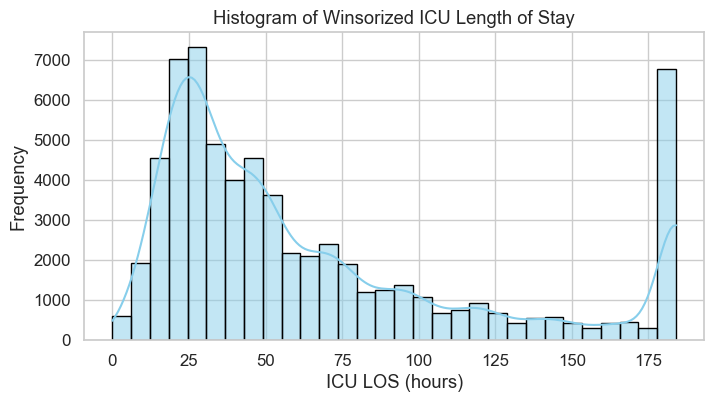

Histogram of Winsorized ICU Length of Stay (in hours):


Frequency
icu_los_hours_winsorized_bin           
(0.0, 12.268]                      2541
(12.268, 24.535]                  11555
(24.535, 36.803]                  12237
(36.803, 49.07]                    8552
(49.07, 61.338]                    5824
(61.338, 73.605]                   4490
(73.605, 85.873]                   3088
(85.873, 98.14]                    2630
(98.14, 110.408]                   1757
(110.408, 122.675]                 1684
(122.675, 134.943]                 1113
(134.943, 147.211]                 1130
(147.211, 159.478]                  732
(159.478, 171.746]                  877
(171.746, 184.013]                 7077

Number of records capped at the upper bound: 0


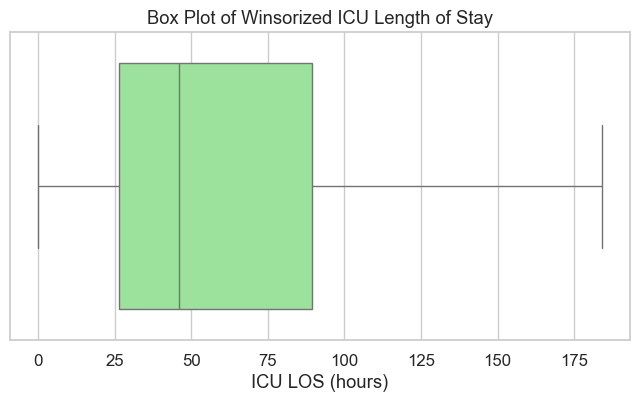

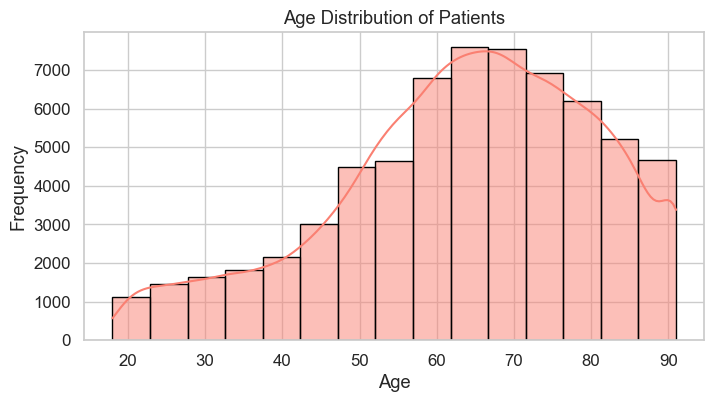

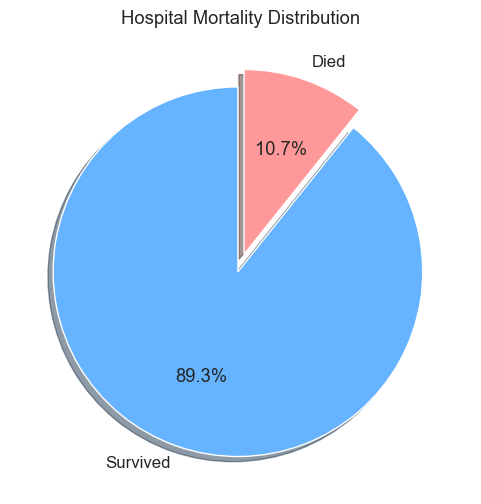

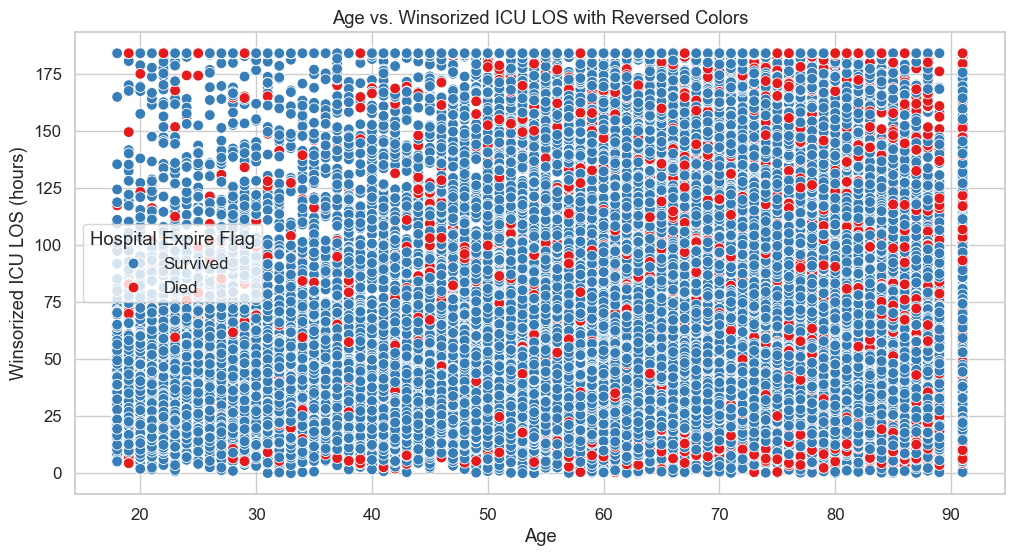

In [10]:
# Visualization 1: Histogram of Winsorized ICU Length of Stay
plt.figure(figsize=(8, 4))
sns.histplot(patient_trajectories['icu_los_hours_winsorized'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Histogram of Winsorized ICU Length of Stay")
plt.xlabel("ICU LOS (hours)")
plt.ylabel("Frequency")
plt.show()

# Define bin boundaries (15 bins between 0 and the upper bound)
# upper_bound = 192.4117361111111
bins = np.linspace(lower_bound, upper_bound, 16)  # 16 boundaries create 15 bins

# Create a new column that bins the winsorized ICU LOS values
patient_trajectories['icu_los_hours_winsorized_bin'] = pd.cut(patient_trajectories['icu_los_hours_winsorized'], bins)

# Count the number of records in each bin
bin_counts = patient_trajectories['icu_los_hours_winsorized_bin'].value_counts().sort_index()

# Display the counts in a table format
print("Histogram of Winsorized ICU Length of Stay (in hours):")
display(bin_counts.to_frame("Frequency"))

num_capped = (patient_trajectories['icu_los_hours_winsorized'] == upper_bound).sum()
print("Number of records capped at the upper bound:", num_capped)


# Visualization 2: Box Plot for Winsorized ICU LOS to visually inspect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=patient_trajectories['icu_los_hours_winsorized'], color='lightgreen')
plt.title("Box Plot of Winsorized ICU Length of Stay")
plt.xlabel("ICU LOS (hours)")
plt.show()

# Visualization 3: Age distribution (if using anchor_age)
plt.figure(figsize=(8, 4))
sns.histplot(patient_trajectories['anchor_age'], bins=15, kde=True, color='salmon', edgecolor='black')
plt.title("Age Distribution of Patients")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Outcome distribution: Hospital Mortality
plt.figure(figsize=(6, 6))
outcome_counts = patient_trajectories['hospital_expire_flag'].value_counts()
plt.pie(outcome_counts, labels=['Survived', 'Died'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90, explode=(0.05, 0.05), shadow=True)
plt.title("Hospital Mortality Distribution")
plt.show()

plt.figure(figsize=(12, 6))
# Create a reversed Set1 palette with two colors
reversed_palette = sns.color_palette("Set1", n_colors=2)[::-1]

ax = sns.scatterplot(
    data=patient_trajectories,
    x='anchor_age',
    y='icu_los_hours_winsorized',
    hue='hospital_expire_flag',
    hue_order=[0, 1],
    palette=reversed_palette,
    s=60,
    alpha=1.0
)
plt.title('Age vs. Winsorized ICU LOS with Reversed Colors')
plt.xlabel('Age')
plt.ylabel('Winsorized ICU LOS (hours)')

# Adjust the legend to show custom labels
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Died'], title='Hospital Expire Flag')
plt.show()


___
# Section 3: Data Merging & Construction of Patient Trajectories
- Generates visualizations (histograms, pie charts, box plots, density plots, and trajectory plots).
- Visualizes missing data proportions and clinical measurement trends.

### Chartevents and Labevents:

- Filter the variables (vital signs, labs, etc.) that are relevant to your analysis.

- Convert time columns (typically "charttime" or similar) to datetime objects.

- Handle missing or erroneous entries in these large, high-frequency datasets.

- Optionally, aggregate the data over meaningful time intervals (e.g., hourly averages) to simplify later analysis.

### d_items:

- Clean the dictionary table so that you can map item IDs from chartevents and labevents to human-readable descriptions. This mapping is essential for understanding what each measurement represents and for selecting features.

## Merge the Time-Series Data with the Static Patient Trajectories:

- Use common identifiers (e.g., subject_id and hadm_id) to merge the time-series data with your merged static dataset (patients, admissions, icustays).

- Filter the time-series data so that only events occurring during the relevant periods (e.g., during an ICU stay) are included.
For example, you can filter events between intime and outtime from your ICU stays.

## Feature Extraction and Construction of Patient Trajectories:

- Once the data is merged, the next step is to extract features from the time-series data. This might involve:

- Creating sequences of time-ordered events or aggregating measurements over time windows.

- Applying data augmentation (e.g., temporal perturbations, noise injection) if you plan to use contrastive learning.

- Finally, organize these features into a format (like sequences or fixed-length embeddings) suitable for your downstream contrastive learning and clustering tasks.

- **Define File Paths:**
  - Construct paths for `chartevents.csv`, `d_items.csv`, and `feature_group_mapping.csv` using `os.path.join(DATA_PATH, ...)`.

- **Set Up Output Directory:**
  - Define the output directory as `processed_chunks_grouped` within `DATA_PATH`.
  - Ensure the directory exists by calling `os.makedirs(output_dir, exist_ok=True)`.

In [11]:
# ===========================
# PARAMETERS & FILE PATHS
# ===========================

chartevents_file = os.path.join(DATA_PATH, 'chartevents.csv')
d_items_file = os.path.join(DATA_PATH, 'd_items.csv')
mapping_file = os.path.join(DATA_PATH, 'feature_group_mapping.csv')
output_dir = os.path.join(DATA_PATH, 'processed_chunks_grouped')
os.makedirs(output_dir, exist_ok=True)

### Load `d_items.csv` and `feature_group_mapping.csv`

- Print a message indicating the start of merging d_items with group mapping.
- Load `d_items` from CSV using only `itemid` and `label` columns; rename `label` to `feature`.
- Inspect the loaded `d_items` table.
- Load `feature_group_mapping` from CSV and inspect the mapping table.
- Merge `d_items` with `feature_group_mapping` on `feature` (left) and `original_feature` (right) using a left join.
- Inspect the merged table to verify the merge results.
- Fill missing values in the column (referenced by `feature_col_name`) with "Unmapped Feature".
- Inspect the merged table after applying the fallback.
- Create the final mapping DataFrame `d_items_grouped` with columns `itemid`, `feature`, and `group_rep`.
- Inspect the final grouped mapping table and print its shape.
- Print the number of unique feature groups after fallback using the column referenced by `feature_col_name`.

Loading and merging d_items with group mapping (with fallback)...
--- Inspecting ../data/d_items.csvTable after Loading ---
Shape (rows, columns): (4095, 2)

First 5 Rows:


itemid                  feature
0  220001             Problem List
1  220003       ICU Admission date
2  220045               Heart Rate
3  220046  Heart rate Alarm - High
4  220047   Heart Rate Alarm - Low


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
itemid             4095           0
feature            4095           0

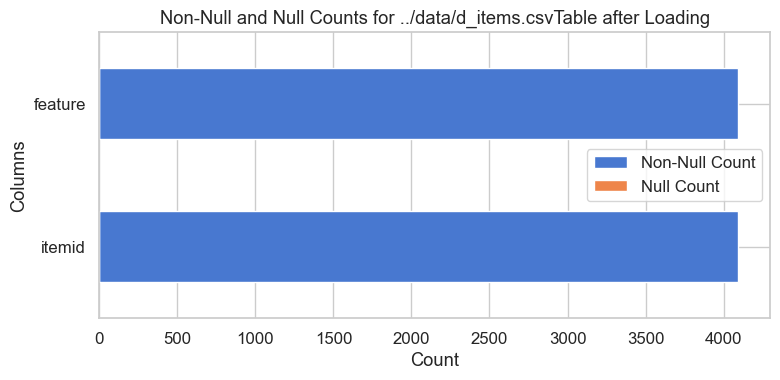

--- Inspecting ../data/feature_group_mapping.csv Table after Loading ---
Shape (rows, columns): (221, 2)

First 5 Rows:


original_feature                    group_rep
0              Safety Measures                       Safety
1                   Heart Rate                   Heart Rate
2             Respiratory Rate             Respiratory Rate
3  O2 saturation pulseoxymetry  O2 saturation pulseoxymetry
4                 Heart Rhythm               Cardiovascular


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
original_feature             221           0
group_rep                    221           0

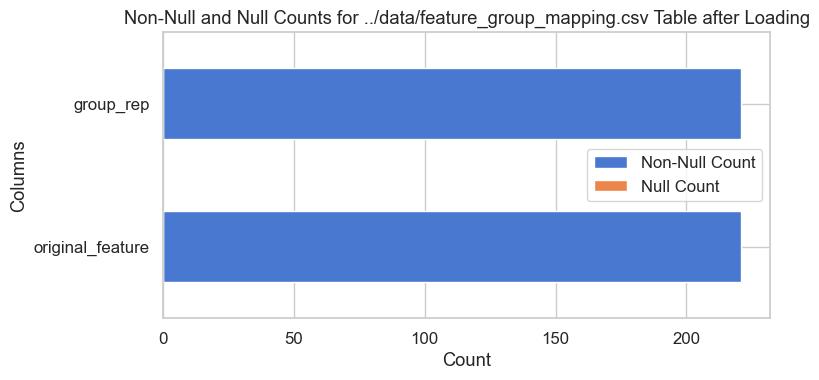

--- Inspecting Merged d_item + mapping table ---
Shape (rows, columns): (4097, 4)

First 5 Rows:


itemid                  feature         original_feature       group_rep
0  220001             Problem List                      NaN             NaN
1  220003       ICU Admission date                      NaN             NaN
2  220045               Heart Rate               Heart Rate      Heart Rate
3  220046  Heart rate Alarm - High  Heart rate Alarm - High  Cardiovascular
4  220047   Heart Rate Alarm - Low   Heart Rate Alarm - Low  Cardiovascular


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
itemid                      4097           0
feature                     4097           0
original_feature             180        3917
group_rep                    180        3917

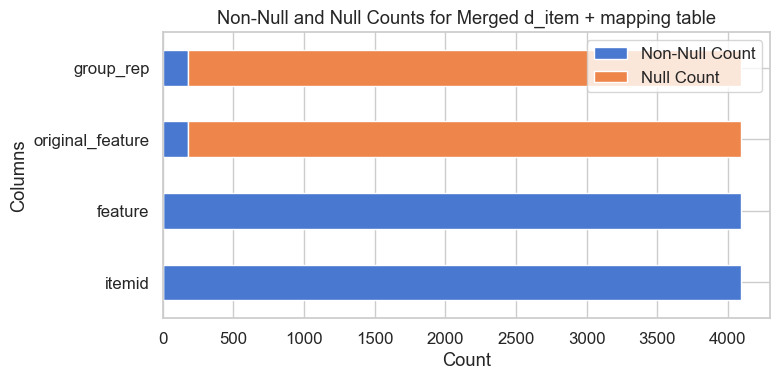

--- Inspecting Merged d_item + mapping table with fillna ---
Shape (rows, columns): (4097, 4)

First 5 Rows:


itemid                  feature         original_feature         group_rep
0  220001             Problem List                      NaN  Unmapped Feature
1  220003       ICU Admission date                      NaN  Unmapped Feature
2  220045               Heart Rate               Heart Rate        Heart Rate
3  220046  Heart rate Alarm - High  Heart rate Alarm - High    Cardiovascular
4  220047   Heart Rate Alarm - Low   Heart Rate Alarm - Low    Cardiovascular


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
itemid                      4097           0
feature                     4097           0
original_feature             180        3917
group_rep                   4097           0

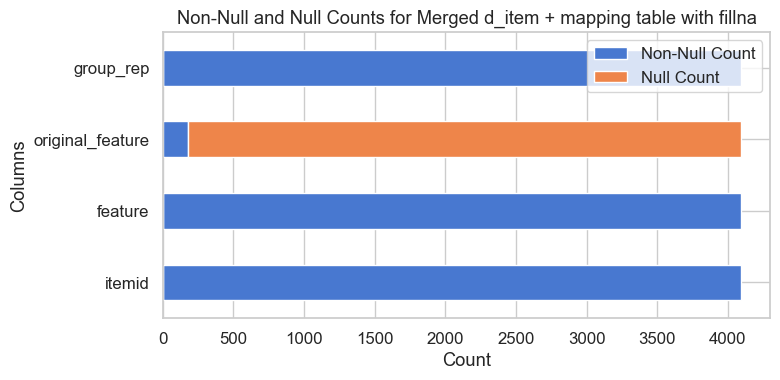

--- Inspecting Group Merged d_item + mapping table ---
Shape (rows, columns): (4097, 3)

First 5 Rows:


itemid                  feature         group_rep
0  220001             Problem List  Unmapped Feature
1  220003       ICU Admission date  Unmapped Feature
2  220045               Heart Rate        Heart Rate
3  220046  Heart rate Alarm - High    Cardiovascular
4  220047   Heart Rate Alarm - Low    Cardiovascular


Null and Non-Null Counts per Column:


Non-Null Count  Null Count
itemid               4097           0
feature              4097           0
group_rep            4097           0

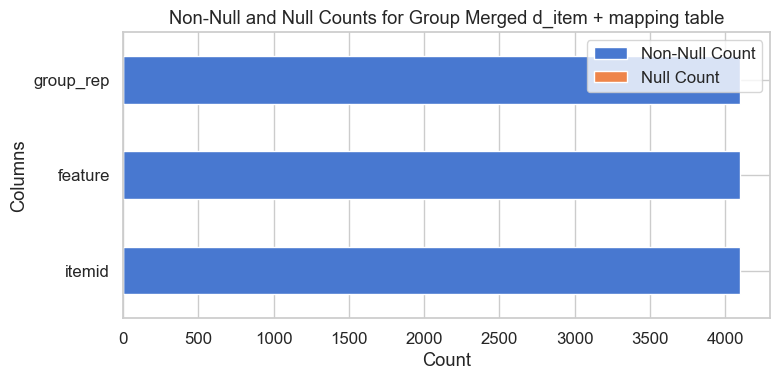

*** Merged d_items shape: (4097, 3)
*** Unique feature groups feature after fallback: 42


In [12]:
print("Loading and merging d_items with group mapping (with fallback)...")
d_items = pd.read_csv(d_items_file, usecols=['itemid', 'label']).rename(columns={'label': 'feature'})
inspect_table(d_items, d_items_file + 'Table after Loading')
feature_group_mapping = pd.read_csv(mapping_file)
inspect_table(feature_group_mapping, mapping_file + ' Table after Loading')

# Merge and apply fallback for missing mappings
merged = d_items.merge(feature_group_mapping, left_on='feature', right_on='original_feature', how='left')
inspect_table(merged, 'Merged d_item + mapping table')

# group_rep to feature change
merged[feature_col_name] = merged[feature_col_name].fillna("Unmapped Feature")

inspect_table(merged, 'Merged d_item + mapping table with fillna')

# Final itemid-to-feature mapping
d_items_grouped = merged[['itemid', 'feature', 'group_rep']]
inspect_table(d_items_grouped, 'Group Merged d_item + mapping table')
print(f"*** Merged d_items shape: {d_items_grouped.shape}")
# group_rep to feature change
print(f"*** Unique feature groups feature after fallback: {d_items_grouped[feature_col_name].nunique()}")

#### Load `chartevents.csv`

- **PART 1: Frequency Analysis**
  - Initialize an empty dictionary `itemid_counts` for counting item occurrences.
  - Print message indicating the start of frequency analysis.
  - Loop through CSV chunks (reading only `itemid` column) up to `LIMIT_CHARTEVENTS` with specified `chunksize`.
  - For each chunk:
    - Compute value counts for `itemid`.
    - Update `itemid_counts` with counts from the current chunk.
    - Print progress including chunk number, cumulative size, and number of unique itemids.
  - Create a DataFrame `freq_df` from `itemid_counts`.
  - Filter `freq_df` to keep only itemids with a count ≥ 128.
  - Extract the set `top_itemids` from the filtered DataFrame.
  - Print the total number of top itemids after frequency analysis.

- **PART 2: Process Chunks with Grouping**
  - Initialize an empty list `chunk_files` to store filenames of processed chunks.
  - Print message indicating the start of chunk processing with grouping.
  - Loop through CSV chunks (reading `stay_id`, `charttime`, `itemid`, `valuenum`) up to `LIMIT_CHARTEVENTS`, parsing `charttime` as datetime.
  - For each chunk:
    - Filter rows to include only those where `itemid` is in `top_itemids`.
    - Merge the chunk with `d_items_grouped` on `itemid` to add `feature` and `group_rep`.
    - Drop rows with missing `valuenum` or `charttime`.
    - Aggregate data by grouping on `stay_id`, `charttime`, `feature`, and `group_rep`, computing the mean of `valuenum`.
    - Display the head of the aggregated DataFrame (`chunk_agg`).
    - Save `chunk_agg` as a Parquet file in the output directory.
    - Append the file path to `chunk_files` and print processing details including chunk number and shape.

- **PART 3: Incremental Start Time Calculation**
  - Initialize an empty list `start_times_list` to store minimum charttimes per stay.
  - Print message indicating the start of incremental start time computation.
  - Loop through each file in `chunk_files`:
    - Read the Parquet file.
    - For each `stay_id`, compute the minimum `charttime`.
    - Append the resulting DataFrame to `start_times_list` and print progress.
  - Concatenate all start time DataFrames and group by `stay_id` to obtain the overall minimum `charttime` (renamed to `start_time`).
  - Display the head of the final `start_times_df`.
  - Print the final shape of `start_times_df` indicating all computed start times.


In [13]:
# ===========================
# PART 1: Frequency Analysis
# ===========================
itemid_counts = {}
print("Starting frequency analysis...")

for idx, chunk in enumerate(pd.read_csv(chartevents_file, usecols=['itemid'], nrows=LIMIT_CHARTEVENTS, chunksize=chunksize)):
    counts = chunk['itemid'].value_counts()
    for itemid, count in counts.items():
        itemid_counts[itemid] = itemid_counts.get(itemid, 0) + count
    print(f"Processed chunk {idx + 1}, total size, {chunksize * (idx + 1)}, cumulative unique itemids: {len(itemid_counts)}")

freq_df = pd.DataFrame(itemid_counts.items(), columns=['itemid', 'count'])
freq_df = freq_df[freq_df['count'] >= 128]
top_itemids = set(freq_df['itemid'])
print(f"Frequency analysis completed. Total top itemids: {len(top_itemids)}")

# ===========================
# PART 2: Process Chunks with Grouping
# ===========================
chunk_files = []
print("Starting chunk processing with grouping...")

for i, chunk in enumerate(pd.read_csv(
    chartevents_file,
    usecols=['stay_id', 'charttime', 'itemid', 'valuenum'],
    nrows=LIMIT_CHARTEVENTS,
    chunksize=chunksize,
    parse_dates=['charttime'],
    low_memory=False
)):
    chunk = chunk[chunk['itemid'].isin(top_itemids)]
    #display(chunk.head())
    chunk = chunk.merge(d_items_grouped[['itemid', 'feature','group_rep']], on='itemid', how='inner')
    #display(chunk.head())
    
    # Rename the group_rep in CSV file to feature
    #chunk = chunk.rename(columns={'group_rep': 'feature'})

    chunk.dropna(subset=['valuenum', 'charttime'], inplace=True)

    # Aggregate values by clinical group
    chunk_agg = chunk.groupby(['stay_id', 'charttime', 'feature', 'group_rep'], as_index=False)['valuenum'].mean()
    display(chunk_agg.head())

    chunk_agg.to_parquet(f'{output_dir}/grouped_chunk_{i}.parquet')
    chunk_files.append(f'{output_dir}/grouped_chunk_{i}.parquet')
    print(f"Processed and saved grouped chunk {i + 1}, shape: {chunk_agg.shape}")
display(chunk_agg.head())

# ===========================
# PART 3: Incremental Start Time Calculation
# ===========================
start_times_list = []
print("Computing start times incrementally...")

for idx, file in enumerate(chunk_files):
    chunk = pd.read_parquet(file)
    min_times = chunk.groupby('stay_id', as_index=False)['charttime'].min()
    start_times_list.append(min_times)
    print(f"Computed start times for chunk {idx + 1}")

start_times_df = pd.concat(start_times_list).groupby('stay_id', as_index=False)['charttime'].min().rename(columns={'charttime': 'start_time'})
display(start_times_df.head())
print(f"Start times computed for all stays, shape: {start_times_df.shape}")

Starting frequency analysis...
Processed chunk 1, total size, 33554432.0, cumulative unique itemids: 2096
Processed chunk 2, total size, 67108864.0, cumulative unique itemids: 2231
Frequency analysis completed. Total top itemids: 1730
Starting chunk processing with grouping...


stay_id           charttime                  feature         group_rep  \
0  30001555 2177-09-27 11:50:00   Absolute Count - Basos  Unmapped Feature   
1  30001555 2177-09-27 11:50:00     Absolute Count - Eos  Unmapped Feature   
2  30001555 2177-09-27 11:50:00  Absolute Count - Lymphs  Unmapped Feature   
3  30001555 2177-09-27 11:50:00   Absolute Count - Monos  Unmapped Feature   
4  30001555 2177-09-27 11:50:00   Absolute Count - Neuts  Unmapped Feature   

   valuenum  
0      0.01  
1      0.00  
2      0.54  
3      0.96  
4      9.98

Processed and saved grouped chunk 1, shape: (12848737, 5)


stay_id           charttime                           feature  \
0  30003226 2123-02-26 16:00:00  Dwell Time (Peritoneal Dialysis)   
1  30003226 2123-02-26 16:04:00             Admission Weight (Kg)   
2  30003226 2123-02-26 16:14:00                        Heart Rate   
3  30003226 2123-02-26 16:14:00                  Respiratory Rate   
4  30003226 2123-02-26 16:15:00       O2 saturation pulseoxymetry   

                     group_rep  valuenum  
0             Unmapped Feature       1.0  
1             Unmapped Feature      91.8  
2                   Heart Rate      89.0  
3             Respiratory Rate      19.0  
4  O2 saturation pulseoxymetry      99.0

Processed and saved grouped chunk 2, shape: (12961022, 5)


stay_id           charttime                           feature  \
0  30003226 2123-02-26 16:00:00  Dwell Time (Peritoneal Dialysis)   
1  30003226 2123-02-26 16:04:00             Admission Weight (Kg)   
2  30003226 2123-02-26 16:14:00                        Heart Rate   
3  30003226 2123-02-26 16:14:00                  Respiratory Rate   
4  30003226 2123-02-26 16:15:00       O2 saturation pulseoxymetry   

                     group_rep  valuenum  
0             Unmapped Feature       1.0  
1             Unmapped Feature      91.8  
2                   Heart Rate      89.0  
3             Respiratory Rate      19.0  
4  O2 saturation pulseoxymetry      99.0

Computing start times incrementally...
Computed start times for chunk 1
Computed start times for chunk 2


stay_id          start_time
0  30001555 2177-09-27 11:50:00
1  30002925 2134-06-05 02:27:00
2  30003087 2132-12-01 20:58:00
3  30003226 2123-02-26 16:00:00
4  30003372 2170-06-10 03:00:00

Start times computed for all stays, shape: (14625, 2)


- **Incremental Elapsed Hours Filtering:**
  - Initialize an empty list `final_chunk_files`.
  - Loop through each file in `chunk_files`:
    - Read the chunk from a Parquet file.
    - Merge with `start_times_df` on `stay_id` to get the start time.
    - Calculate `elapsed_hours` as the difference between `charttime` and `start_time` (in hours).
    - Filter rows where `elapsed_hours` is less than `TREND_DURATION`.
    - Save the filtered chunk as a Parquet file and add its path to `final_chunk_files`.
    - Print progress with chunk number and shape.
  - Display the head of the last processed chunk.

- **Final Hourly Aggregation by Clinical Group:**
  - Initialize an empty list `agg_chunks`.
  - Loop through each file in `final_chunk_files`:
    - Read the chunk from the Parquet file.
    - Drop the `start_time` column if it exists.
    - Sort by `charttime` and set it as the index.
    - Create an hourly bucket by flooring `charttime` to the nearest hour.
    - Group by `stay_id`, feature (referenced by `feature_col_name`), and the hourly bucket; compute the mean of `valuenum`.
    - Reset the index and rename the hourly bucket column back to `charttime`.
    - Pivot the DataFrame so that each feature becomes a column with its mean value.
    - Reset index and append the result to `agg_chunks`.
    - Print aggregation details for the current chunk.
  - Concatenate all aggregated chunks into `final_grouped_df`.
  - Save `final_grouped_df` as a Parquet file.
  - Display the head of `final_grouped_df` and print its final shape.

Starting incremental elapsed time filtering...
Chunk 1 processed, events within 36 hours: (4619452, 7)
Chunk 2 processed, events within 36 hours: (4547476, 7)


stay_id           charttime                           feature  \
0  30003226 2123-02-26 16:00:00  Dwell Time (Peritoneal Dialysis)   
1  30003226 2123-02-26 16:04:00             Admission Weight (Kg)   
2  30003226 2123-02-26 16:14:00                        Heart Rate   
3  30003226 2123-02-26 16:14:00                  Respiratory Rate   
4  30003226 2123-02-26 16:15:00       O2 saturation pulseoxymetry   

                     group_rep  valuenum          start_time  elapsed_hours  
0             Unmapped Feature       1.0 2123-02-26 16:00:00       0.000000  
1             Unmapped Feature      91.8 2123-02-26 16:00:00       0.066667  
2                   Heart Rate      89.0 2123-02-26 16:00:00       0.233333  
3             Respiratory Rate      19.0 2123-02-26 16:00:00       0.233333  
4  O2 saturation pulseoxymetry      99.0 2123-02-26 16:00:00       0.250000

Starting final hourly aggregation by clinical group...
Aggregated hourly grouped data for chunk 1, shape: (216464, 32)
Aggregated hourly grouped data for chunk 2, shape: (211619, 31)


group_rep   stay_id           charttime  Assessment  Blood Pressure  \
0          30001555 2177-09-27 11:00:00         NaN             NaN   
1          30001555 2177-09-27 12:00:00         1.0       92.666667   
2          30001555 2177-09-27 13:00:00         NaN       94.333333   
3          30001555 2177-09-27 14:00:00         NaN       90.333333   
4          30001555 2177-09-27 15:00:00         NaN       86.000000   

group_rep  Cardiovascular  Critical Care  Dialysis  Discharge Planning  ECMO  \
0                     NaN            NaN       NaN                 NaN   NaN   
1                    90.0            0.0       NaN                 NaN   NaN   
2                     NaN            NaN       NaN                 NaN   NaN   
3                     NaN            NaN       NaN                 NaN   NaN   
4                     NaN            NaN       NaN                 NaN   NaN   

group_rep  Equipment  ...  Oxygenation  Pain Scale  Patient Education  \
0                NaN  ...          NaN         NaN                NaN   
1                1.0  ...          NaN         NaN                NaN   
2                NaN  ...          NaN         NaN                NaN   
3                NaN  ...          NaN         NaN                NaN   
4                NaN  ...          NaN         NaN                NaN   

group_rep  Respiratory  Respiratory Rate  Skin/Tissue  Temperature  \
0                  NaN               NaN          NaN          NaN   
1                 30.0              14.0          2.5         98.3   
2                  NaN              15.0          NaN          NaN   
3                  NaN              12.0          NaN         98.3   
4                  NaN              33.0          NaN          NaN   

group_rep  Unmapped Feature  Vascular Access  Vital Signs  
0                 20.599474              NaN          NaN  
1                 29.470588              NaN          NaN  
2                       NaN              NaN          NaN  
3                  0.750000              NaN          NaN  
4                       NaN              NaN          NaN  

[5 rows x 32 columns]

 *** Final grouped aggregation complete. Data shape: (428083, 32)


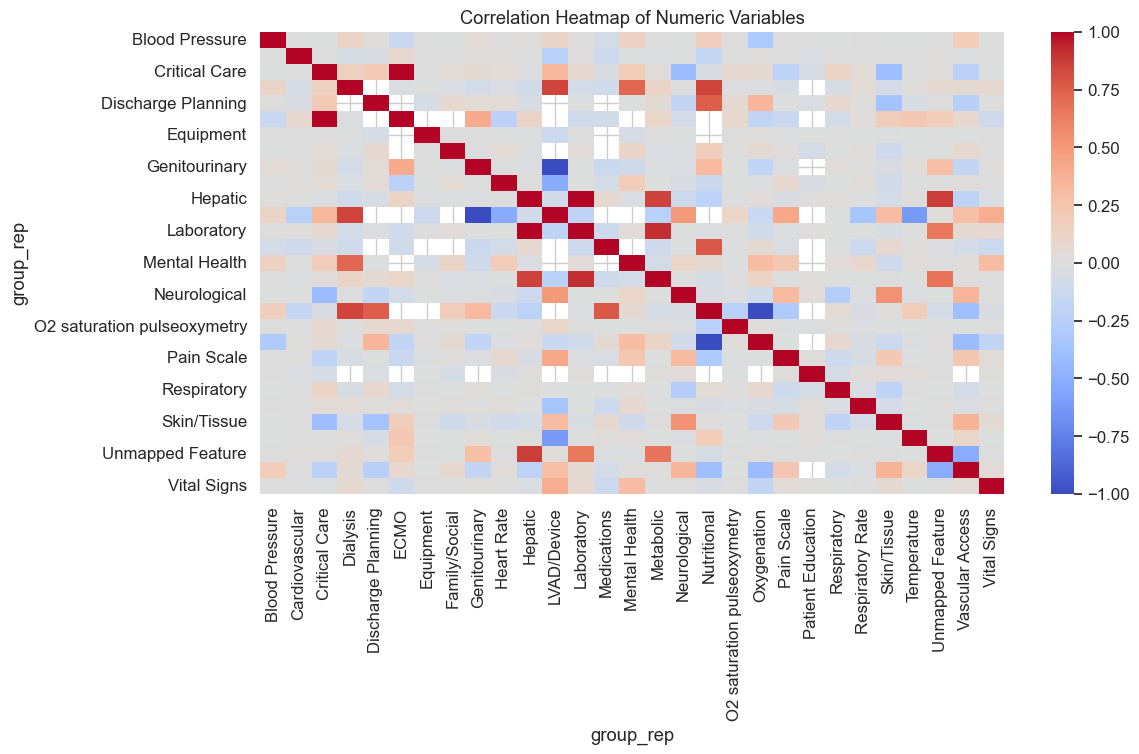

In [14]:
# ===========================
# PART 4: Incremental Elapsed Hours Filtering
# ===========================

final_chunk_files = []
print("Starting incremental elapsed time filtering...")
for idx, file in enumerate(chunk_files):
    chunk = pd.read_parquet(file)
    # display(chunk.head())
    chunk = chunk.merge(start_times_df, on='stay_id', how='left')
    # display(chunk.head())
    chunk['elapsed_hours'] = (chunk['charttime'] - chunk['start_time']).dt.total_seconds() / 3600
    chunk = chunk[chunk['elapsed_hours'] < TREND_DURATION]
    # display(chunk.head())
    chunk.to_parquet(f'{output_dir}/final_{os.path.basename(file)}')
    final_chunk_files.append(f'{output_dir}/final_{os.path.basename(file)}')
    print(f"Chunk {idx + 1} processed, events within {TREND_DURATION} hours: {chunk.shape}")
display(chunk.head())

agg_chunks = []
print("Starting final hourly aggregation by clinical group...")

for idx, file in enumerate(final_chunk_files):
    df = pd.read_parquet(file)
    # display(df.head())

    # Drop start_time if still present
    if 'start_time' in df.columns:
        df.drop(columns='start_time', inplace=True)

    df.sort_values('charttime', inplace=True)
    df.set_index('charttime', inplace=True)

    # Use fast hour bucketing instead of resample
    df['hour'] = df.index.floor('h')

    # group_rep to feature change
    hourly_agg = (
        df.groupby(['stay_id', feature_col_name, 'hour'], sort=False)['valuenum']
        .mean()
        .reset_index()
        .rename(columns={'hour': 'charttime'})
    )
    # group_rep to feature change
    final_pivot = hourly_agg.pivot(index=['stay_id', 'charttime'], columns=feature_col_name, values='valuenum')
    final_pivot.reset_index(inplace=True)
    
    agg_chunks.append(final_pivot)
    print(f"Aggregated hourly grouped data for chunk {idx + 1}, shape: {final_pivot.shape}")

final_grouped_df = pd.concat(agg_chunks, ignore_index=True)
final_grouped_df.to_parquet(os.path.join(DATA_PATH, 'aggregated_grouped_patient_trajectories.parquet'))
display(final_grouped_df.head())

print(f" *** Final grouped aggregation complete. Data shape: {final_grouped_df.shape}")

# Load aggregated grouped data
df = pd.read_parquet(os.path.join(DATA_PATH, 'aggregated_grouped_patient_trajectories.parquet'))
# display(final_grouped_df.head())

# Select numeric columns for correlation
# numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['stay_id', 'Assessment'], errors='ignore')
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

- **Preview Columns:**  
  - Print current number of columns in `df`.

- **Identify Unmapped Columns:**  
  - List columns starting with "Unmapped Feature".
  - Print the count and names of these unmapped features.

- **Filter Numeric Unmapped Columns:**  
  - Select only numeric columns among the unmapped ones.
  - Print how many are safe to collapse.

- **Collapse to 'OtherFeatures':**  
  - If numeric unmapped columns exist, compute their row-wise mean into a new column `OtherFeatures` and drop the originals.
  - Print confirmation of the collapse.

- **Confirm Updated Columns:**  
  - Print the new total number of columns in `df`.

- **Compute Elapsed Hours per Patient:**  
  - For each `stay_id`, compute the minimum `charttime`.
  - Calculate `elapsed_hours` by subtracting this minimum from each `charttime` (in hours).

In [15]:
# ===========================
# Collapse Unmapped Features Safely
# ===========================

# Step 1: Preview current number of columns
print("*** Columns before collapsing 'Unmapped Feature' →", df.shape[1])

# Step 2: Identify unmapped columns
unmapped_cols = [col for col in df.columns if col.startswith("Unmapped Feature")]
print(f"*** Found {len(unmapped_cols)} unmapped features to collapse into 'OtherFeatures':")
for col in unmapped_cols:
    print("-", col)

# Step 3: Keep only numeric unmapped columns to prevent memory issues
numeric_unmapped_cols = df[unmapped_cols].select_dtypes(include='number').columns.tolist()
print(f"*** Of these, {len(numeric_unmapped_cols)} are numeric and safe to collapse.")

# Step 4: Collapse unmapped numeric features into a new 'OtherFeatures' column
if numeric_unmapped_cols:
    df['OtherFeatures'] = df[numeric_unmapped_cols].mean(axis=1)
    df.drop(columns=numeric_unmapped_cols, inplace=True)
    print("🧹 Collapsed 'Unmapped Feature' numeric columns into 'OtherFeatures' and removed them.")
else:
    print("*** No numeric unmapped columns found. Skipping collapse.")

# Step 5: Confirm resulting number of columns
print("*** Columns after collapsing 'Unmapped Feature' →", df.shape[1])

# ===========================
# Compute elapsed_hours per patient
# ===========================

min_charttime = df.groupby('stay_id')['charttime'].min()
df['elapsed_hours'] = (
    df['charttime'] - df['stay_id'].map(min_charttime)
).dt.total_seconds() / 3600

*** Columns before collapsing 'Unmapped Feature' → 32
*** Found 1 unmapped features to collapse into 'OtherFeatures':
- Unmapped Feature
*** Of these, 1 are numeric and safe to collapse.
🧹 Collapsed 'Unmapped Feature' numeric columns into 'OtherFeatures' and removed them.
*** Columns after collapsing 'Unmapped Feature' → 32


- **Identify Measurement Columns:**
  - Exclude `stay_id`, `charttime`, and `elapsed_hours` from `df` columns.
  - Compute counts for each remaining column and select the top 25 by measurement count.

- **Plot Top 25 Clinical Groups:**
  - Create a barplot of the top 25 clinical groups using the "viridis" palette.
  - Set plot title, axis labels, and rotate x-tick labels for clarity.

- **Prepare and Print Summary Table:**
  - Reset the index of the top groups series and rename columns to "Clinical Group" and "Measurement Count".
  - Print the summary table.

- **Missing Data Proportion Visualization:**
  - Calculate the fraction of missing values for each clinical group (after dropping identifier columns).
  - Plot a barplot with the "Reds_r" palette, set title and axis labels, and rotate x-tick labels.
  - Create and print a summary table of missing data fractions.

___
# Section 4: Visualization of Clinical Data & Trends


📈 Computing measurement counts for all clinical groups (optimized)...
group_rep
Heart Rate                     404525
Respiratory Rate               400678
O2 saturation pulseoxymetry    398589
OtherFeatures                  318453
Blood Pressure                 287557
Respiratory                    127922
Neurological                   125685
Vital Signs                    120106
Equipment                      106102
Temperature                    104898
Assessment                     103887
Metabolic                       99555
Pain Scale                      62280
Skin/Tissue                     60227
Cardiovascular                  49984
Laboratory                      38593
Critical Care                   29677
Family/Social                   18068
Oxygenation                     12410
Hepatic                         11362
Vascular Access                  5629
Discharge Planning               5448
Mental Health                    4410
Patient Education                3711
Genitour

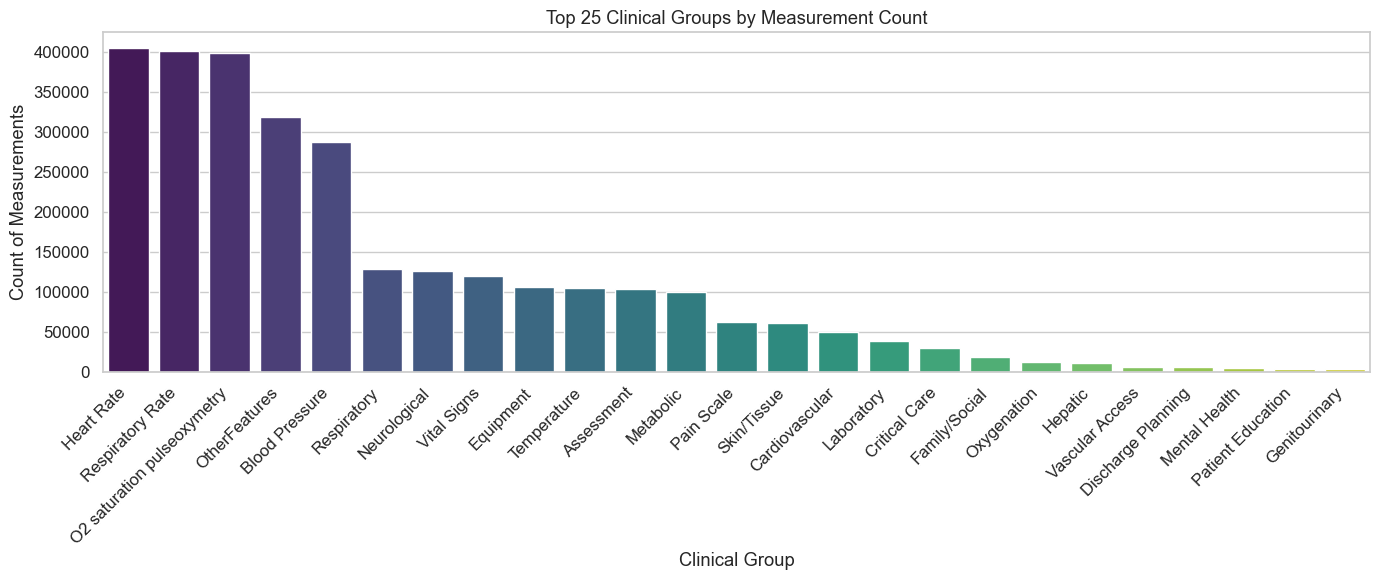

                 Clinical Group  Measurement Count
0                    Heart Rate             404525
1              Respiratory Rate             400678
2   O2 saturation pulseoxymetry             398589
3                 OtherFeatures             318453
4                Blood Pressure             287557
5                   Respiratory             127922
6                  Neurological             125685
7                   Vital Signs             120106
8                     Equipment             106102
9                   Temperature             104898
10                   Assessment             103887
11                    Metabolic              99555
12                   Pain Scale              62280
13                  Skin/Tissue              60227
14               Cardiovascular              49984
15                   Laboratory              38593
16                Critical Care              29677
17                Family/Social              18068
18                  Oxygenation

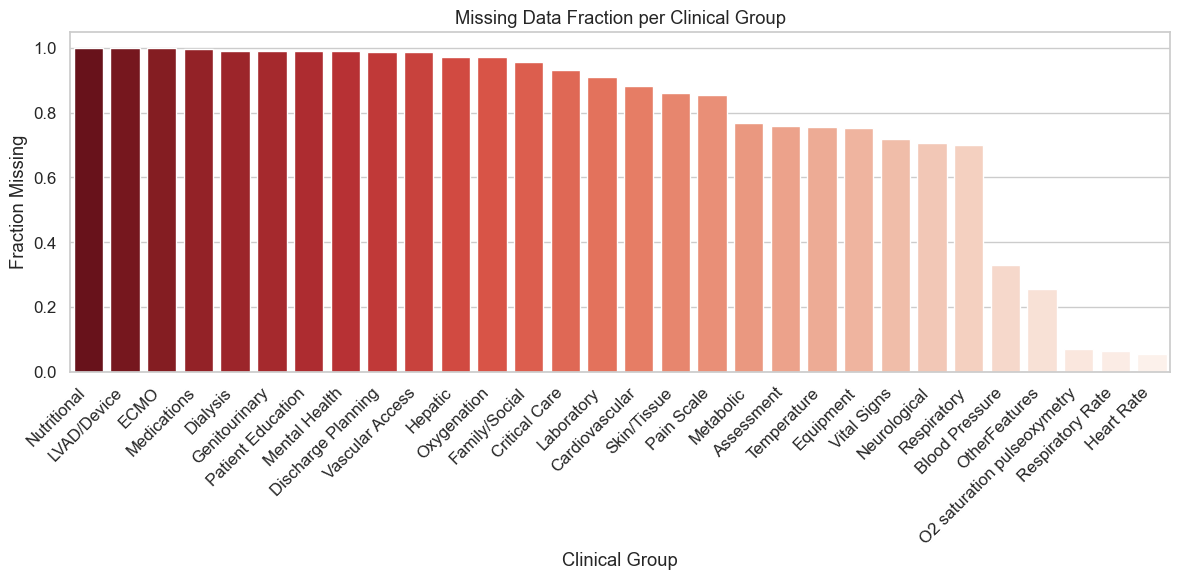

                      group_rep  Missing Fraction
0                   Nutritional          0.999397
1                   LVAD/Device          0.999372
2                          ECMO          0.998921
3                   Medications          0.995225
4                      Dialysis          0.991649
5                 Genitourinary          0.991632
6             Patient Education          0.991331
7                 Mental Health          0.989698
8            Discharge Planning          0.987273
9               Vascular Access          0.986851
10                      Hepatic          0.973458
11                  Oxygenation          0.971010
12                Family/Social          0.957793
13                Critical Care          0.930675
14                   Laboratory          0.909847
15               Cardiovascular          0.883238
16                  Skin/Tissue          0.859310
17                   Pain Scale          0.854514
18                    Metabolic          0.767440


In [16]:
# Visualization : Most Frequent Clinical Groups

# Step 1: Identify measurement columns (excluding identifiers and time)
group_cols = [col for col in df.columns if col not in ['stay_id', 'charttime', 'elapsed_hours']]

print("📈 Computing measurement counts for all clinical groups (optimized)...")
top_groups = df[group_cols].count().nlargest(25)
print(top_groups)

# Step 2: Plot the top 25 most frequent clinical groups
plt.figure(figsize=(14, 6))
sns.barplot(x=top_groups.index, hue=top_groups.index, y=top_groups.values, palette='viridis')
plt.title('Top 25 Clinical Groups by Measurement Count')
plt.ylabel('Count of Measurements')
plt.xlabel('Clinical Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 3: Prepare and print summary table
summary1 = top_groups.reset_index()
summary1.columns = ['Clinical Group', 'Measurement Count']
print(summary1.head(32))

# Visualization : Summary: Missing Data Proportion

missing_summary = df.drop(['stay_id', 'charttime', 'elapsed_hours'], axis=1).isna().mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_summary.index, hue=missing_summary.index, y=missing_summary.values, palette='Reds_r')
plt.title('Missing Data Fraction per Clinical Group')
plt.ylabel('Fraction Missing')
plt.xlabel('Clinical Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

summary2 = missing_summary.reset_index().rename(columns={'index': 'Clinical Group', 0: 'Missing Fraction'})
print(summary2.head(32))


- **Select Sample Patients:**
  - Randomly sample 3 patient `stay_id`s from `df` (using a fixed random state for reproducibility).
  - Initialize an empty list `summary3` to store summary statistics.

- **Set Normalization Threshold:**
  - Define a threshold value (0.1) for normalized feature variation.

- **Loop Over Each Sampled Patient:**
  - Filter `df` for each patient's data and sort by `charttime`, setting it as the index.
  - Drop unneeded columns (`stay_id`, `elapsed_hours`) for plotting.

- **Determine Columns to Plot:**
  - For each column in the patient's data:
    - Check that the column has variation (max minus min > 0).
    - Normalize the column values to a 0–1 scale.
    - Include the column for plotting if the normalized max exceeds the threshold.

- **Plot Clinical Trajectory:**
  - Plot the selected columns with a figure size of (14, 6).
  - Set plot title, labels, and legend with custom formatting.
  - Use tight layout and display the plot.

- **Collect and Summarize Statistics:**
  - Calculate summary statistics (mean, std, min, max) for the plotted features.
  - Add the `stay_id` to the statistics and append to `summary3`.

- **Finalize Summary:**
  - Concatenate all summary statistics into `summary3_df`.
  - Print the first 10 rows of the summary DataFrame.

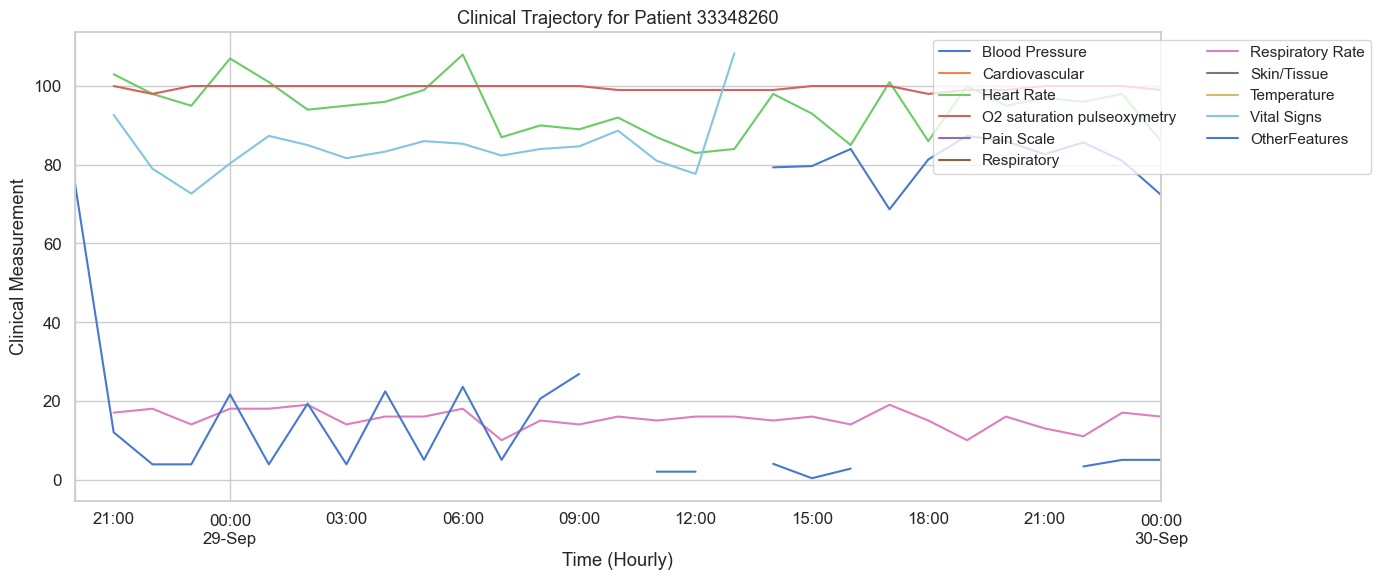

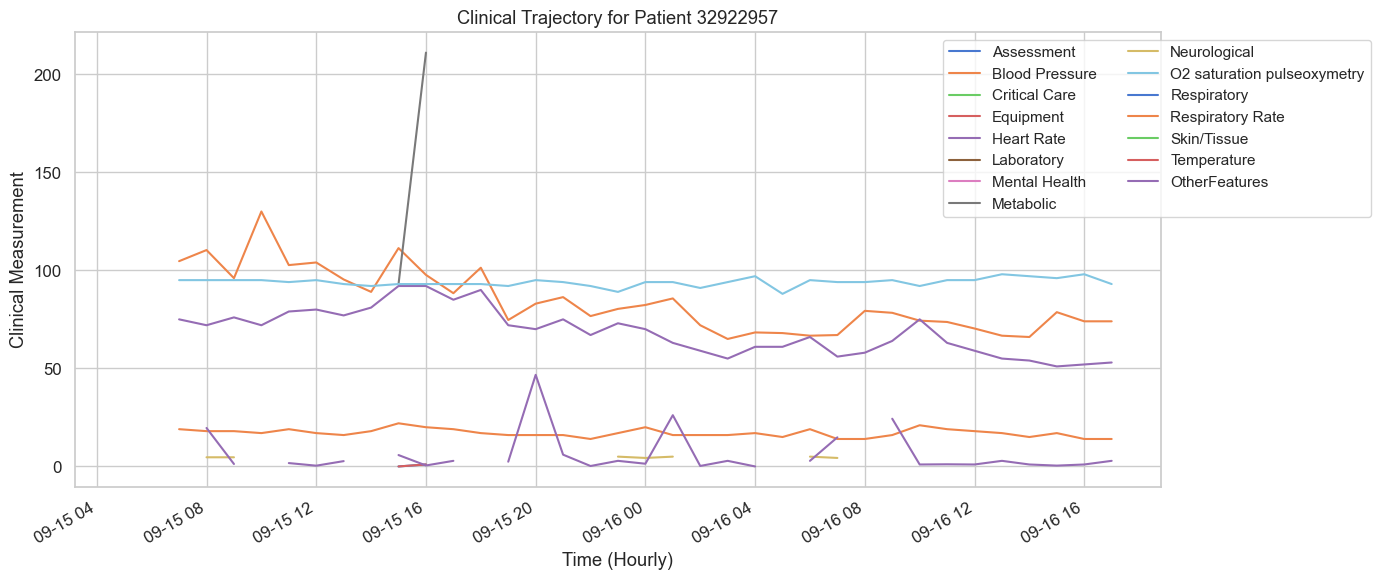

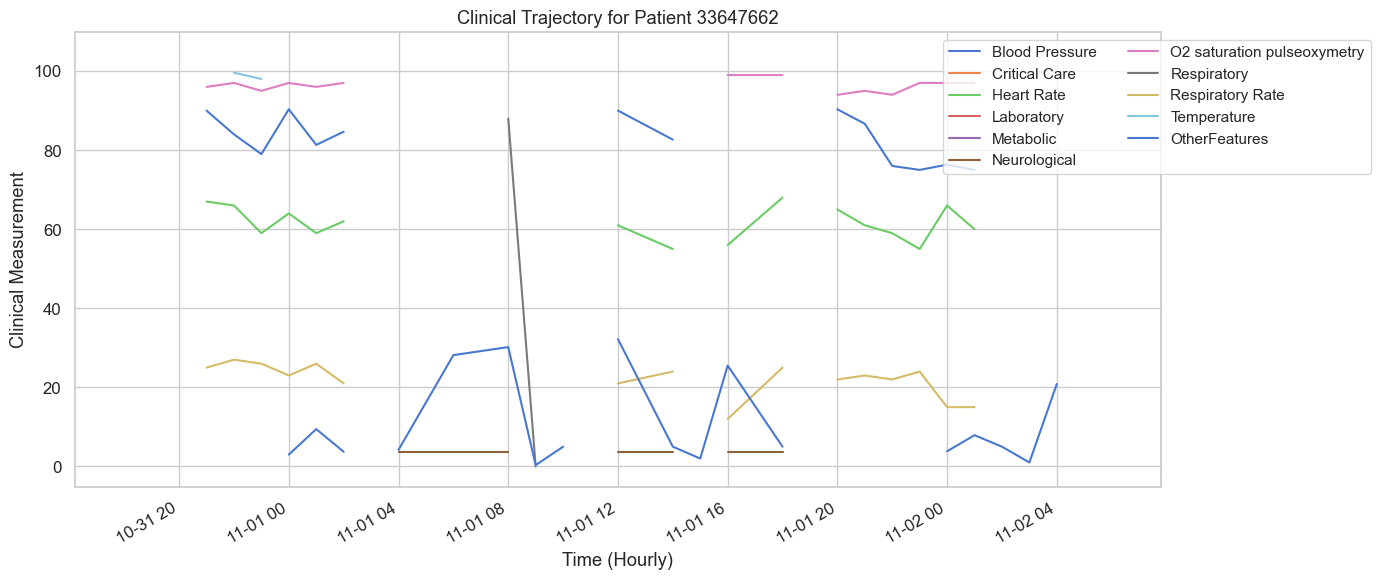

                     group_rep       mean        std        min         max  \
0               Blood Pressure  80.727273   5.742276  68.666667   87.333333   
1               Cardiovascular  87.000000   2.738613  85.000000   90.000000   
2                   Heart Rate  94.392857   6.784183  83.000000  108.000000   
3  O2 saturation pulseoxymetry  99.571429   0.634126  98.000000  100.000000   
4                   Pain Scale   6.100000   2.846050   0.000000    8.000000   
5                  Respiratory  23.619048  16.888993   0.000000   44.000000   
6             Respiratory Rate  15.428571   2.379365  10.000000   19.000000   
7                  Skin/Tissue   3.033333   0.182574   2.833333    3.333333   
8                  Temperature  98.912500   0.527629  98.000000   99.400000   
9                  Vital Signs  84.705882   7.597407  72.666667  108.333333   

    stay_id  
0  33348260  
1  33348260  
2  33348260  
3  33348260  
4  33348260  
5  33348260  
6  33348260  
7  33348260  
8  3

In [17]:
# Visualization : Clinical Trajectory for Patient 

sample_patients = df['stay_id'].sample(3, random_state=42).values
summary3 = []

# Define a threshold on the normalized scale (0 to 1)
threshold = 0.1

for pid in sample_patients:
    # Get the patient's data, sorted by charttime
    patient_df = df[df['stay_id'] == pid].sort_values('charttime').set_index('charttime')
    # Drop columns not needed for plotting
    plot_df = patient_df.drop(columns=['stay_id', 'elapsed_hours'])
    
    # Filter columns: only plot if the normalized max is above the threshold
    cols_to_plot = []
    for col in plot_df.columns:
        col_data = plot_df[col]
        if col_data.max() - col_data.min() > 0:  # Ensure the column has variation
            normalized = (col_data - col_data.min()) / (col_data.max() - col_data.min())
            if normalized.max() > threshold:
                cols_to_plot.append(col)
    
    # Plot only the selected significant features
    plot_df[cols_to_plot].plot(figsize=(14, 6))
    plt.title(f'Clinical Trajectory for Patient {pid}')
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Clinical Measurement')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    
    # Collect summary statistics for the plotted features
    stats = plot_df[cols_to_plot].describe().transpose()[['mean', 'std', 'min', 'max']]
    stats['stay_id'] = pid
    summary3.append(stats.reset_index().rename(columns={'index': 'Clinical Group'}))

summary3_df = pd.concat(summary3)
print(summary3_df.head(10))

- **Step 1: Top Measured Clinical Groups**
  - Compute measurement counts for all clinical groups using `df[group_cols].count()`.
  - Identify the top 10 groups with the highest counts (`nlargest(10)`).

- **Step 2: Density Plots for Top Groups**
  - Plot density curves for the top 10 clinical groups with subplots.
  - Set figure size, title, and axis labels.
  - Loop through each subplot to add x-axis ("Clinical Measurement Values") and y-axis ("Probability Density") labels.
  - Adjust layout, add a descriptive text note at the bottom, and display the plot.

- **Step 3: Replace Unmapped Feature Names**
  - Replace any column names starting with "Unmapped Feature" with the common label "OtherValues".

- **Step 4: Hourly Trends (First Few Hours)**
  - Select numeric columns (excluding `stay_id` and `elapsed_hours`).
  - Group data by `elapsed_hours` and compute the mean for each numeric column.
  - Filter the grouped data to include only elapsed hours between 0 and `TREND_DURATION`.
  - Create subplots for each numeric column:
    - Plot hourly mean values with markers.
    - Set individual subplot titles and grid.
    - Force x-axis limits from 0 to `TREND_DURATION` with hourly ticks.
    - Only label the x-axis on the bottom subplot.
  - Adjust vertical spacing and display the plot.

- **Step 5: Display Summary Table**
  - Extract and print the summary table (first 10 hours) from the hourly means DataFrame.

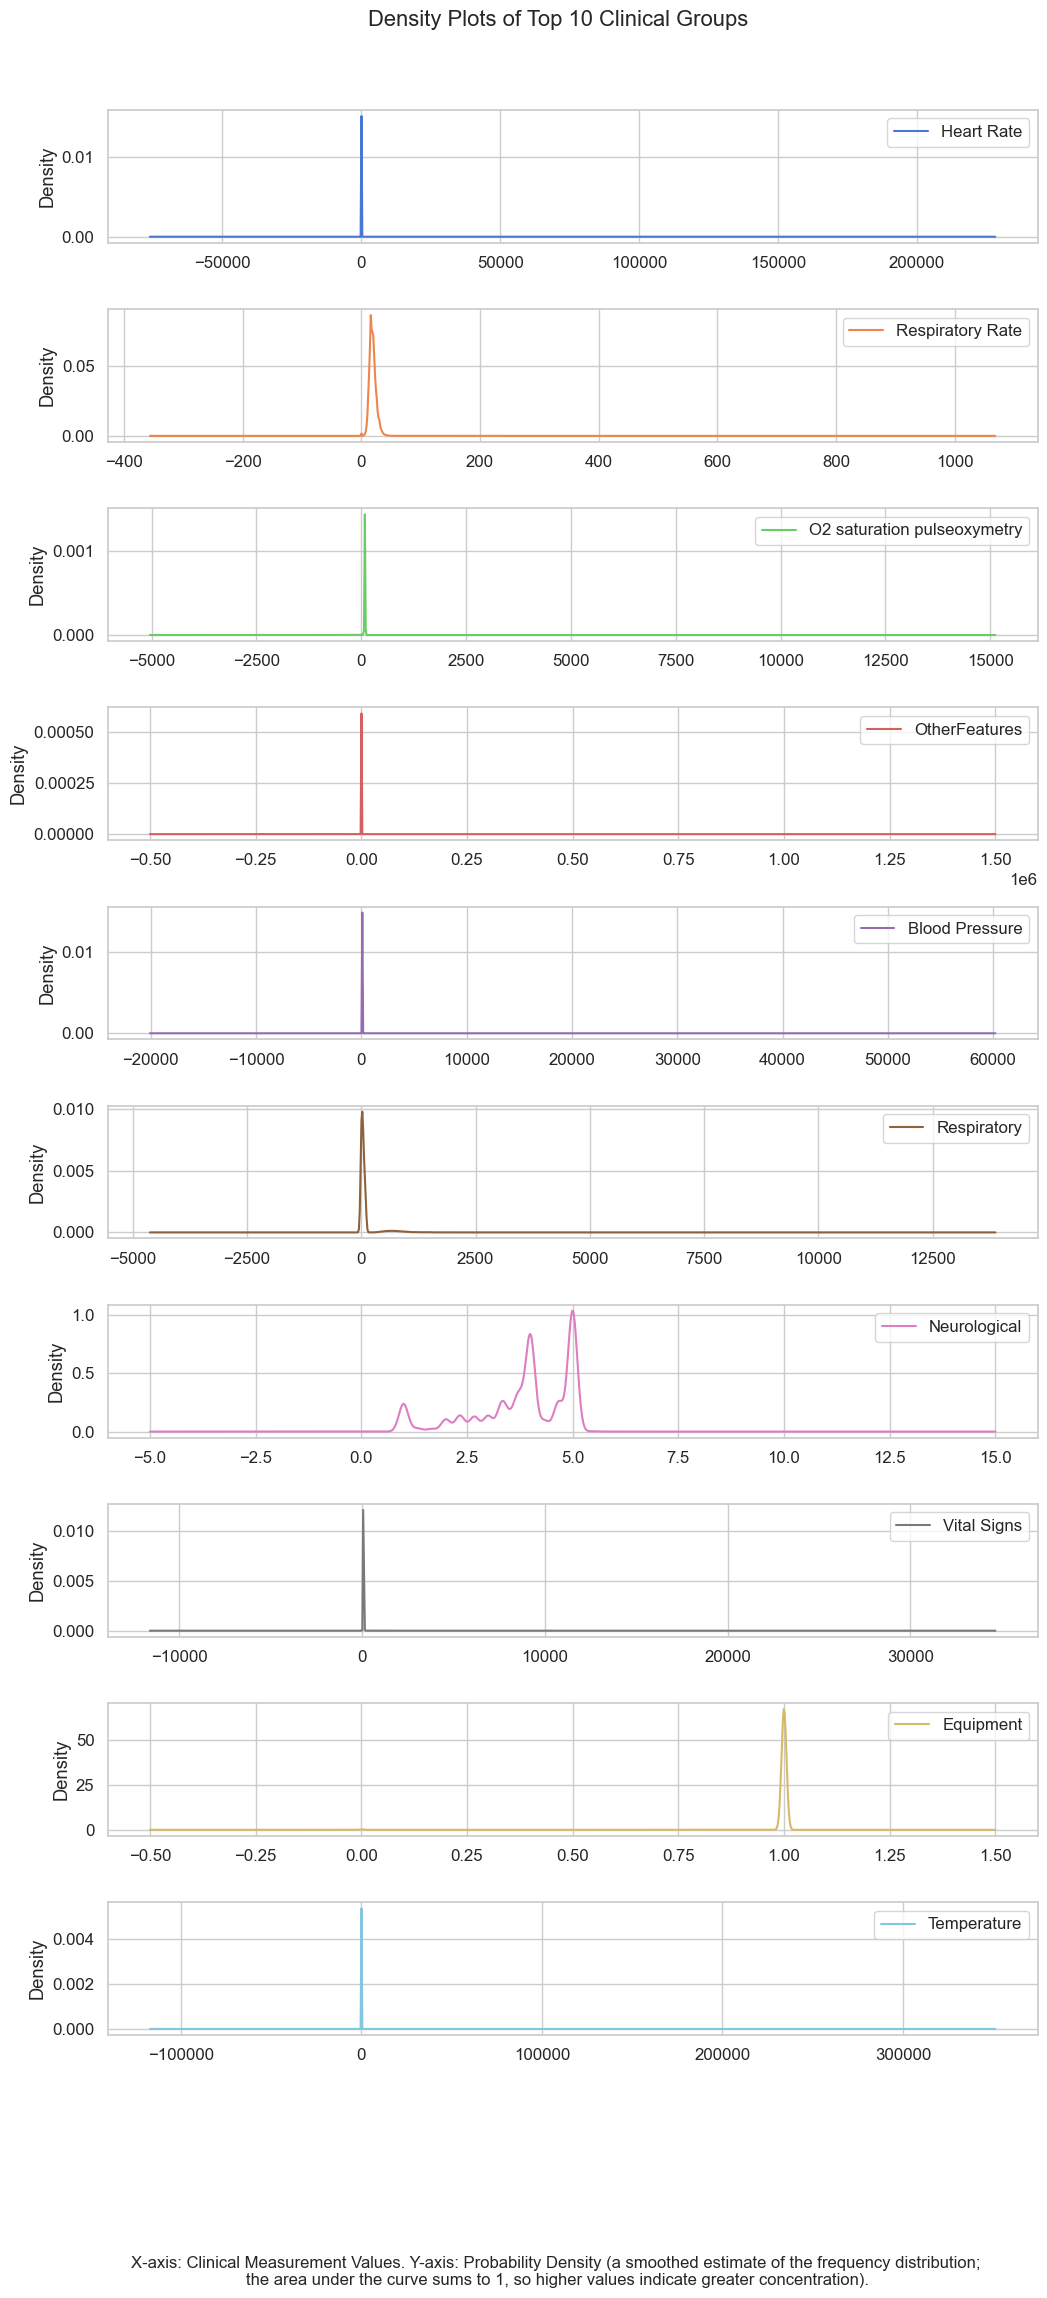

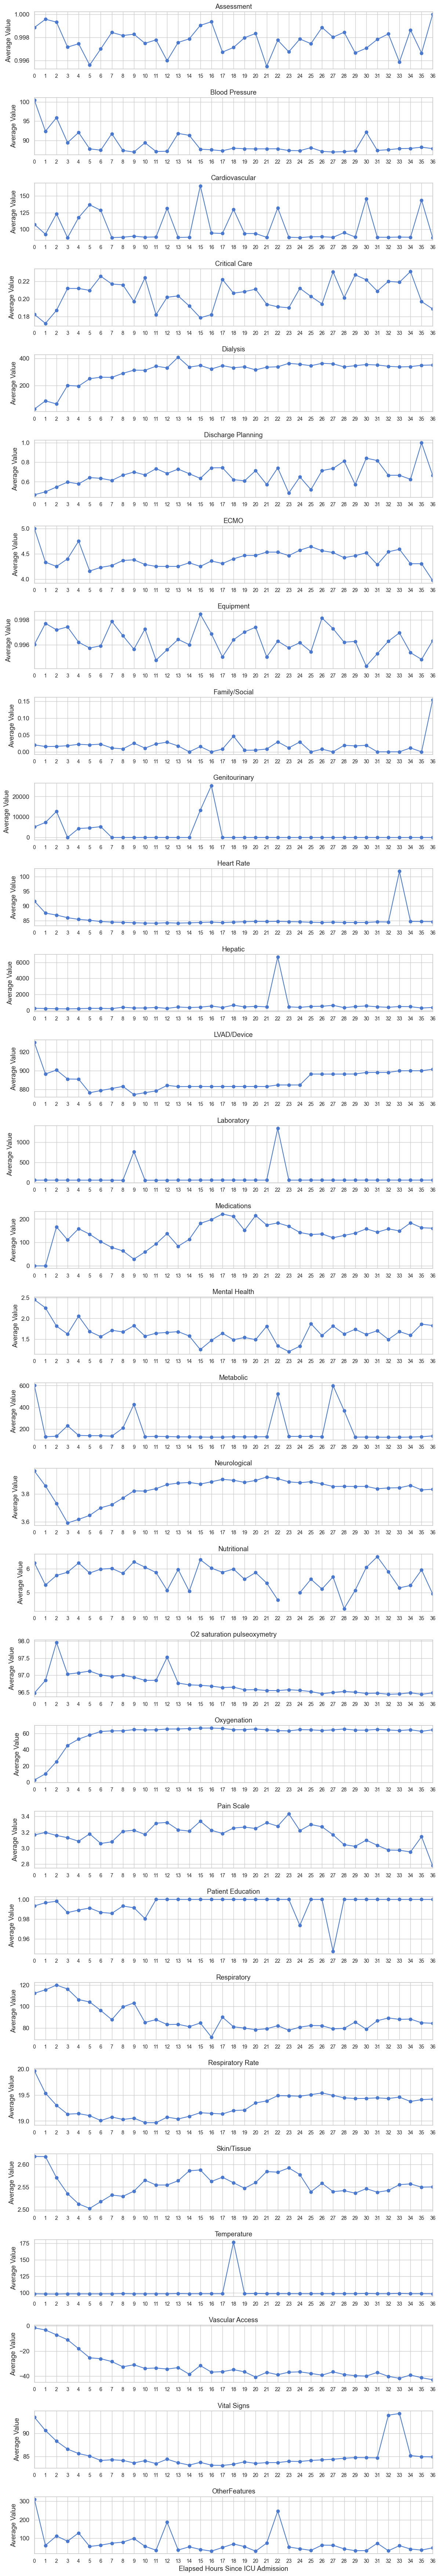

   elapsed_hours  Assessment  Blood Pressure  Cardiovascular  Critical Care  \
0            0.0    0.998861      100.489032      107.592623       0.182367   
1            1.0    0.999582       92.354507       92.777647       0.172010   
2            2.0    0.999336       95.908294      123.201505       0.186951   
3            3.0    0.997166       89.393811       87.621233       0.211988   
4            4.0    0.997458       92.041740      117.631325       0.212007   
5            5.0    0.995613       87.776098      136.617043       0.209763   
6            6.0    0.997010       87.426841      128.429296       0.225968   
7            7.0    0.998441       91.724994       87.820366       0.217099   
8            8.0    0.998171       87.354431       88.387750       0.216087   
9            9.0    0.998285       86.946907       89.861920       0.197140   

     Dialysis  Discharge Planning      ECMO  Equipment  Family/Social  ...  \
0   25.000000            0.466387  5.000000   0.9960

In [18]:
# Step 1: Get top-measured clinical groups
group_counts = df[group_cols].count()
top_groups = group_counts.nlargest(10).index.tolist()

# Step 2: Plot density for these top groups only
df[top_groups].plot(kind='density', subplots=True, layout=(len(top_groups), 1),
                    figsize=(12, 2.5 * len(top_groups)), sharex=False)


# Loop over each subplot to add axis labels
for ax in axes.flatten():
    ax.set_xlabel("Clinical Measurement Values")
    ax.set_ylabel("Probability Density")

plt.suptitle('Density Plots of Top 10 Clinical Groups', y=0.92)
plt.subplots_adjust(hspace=0.5)

# Add descriptive text at the bottom of the figure
description = (
    "X-axis: Clinical Measurement Values. "
    "Y-axis: Probability Density (a smoothed estimate of the frequency distribution; \n"
    "the area under the curve sums to 1, so higher values indicate greater concentration)."
)
plt.figtext(0.5, 0.01, description, ha="center", fontsize=12)

plt.show()

# Replace feature names starting with 'Unmapped Feature' with a common label 'OtherValues'
df.columns = [
    'OtherValues' if col.startswith('Unmapped Feature') else col 
    for col in df.columns
]

# Visualization : Hourly Trends (First few Hours)

# Step 1: Explicitly select numeric columns (excluding identifiers and elapsed_hours)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(['stay_id', 'elapsed_hours'], errors='ignore')

# Step 2: Compute hourly means grouped by elapsed_hours
hourly_means = df.groupby('elapsed_hours')[numeric_cols].mean().reset_index()

# Step 3: Ensure elapsed_hours are within realistic limits (First few hours)
hourly_means = hourly_means[
    (hourly_means['elapsed_hours'] >= 0) & 
    (hourly_means['elapsed_hours'] <= TREND_DURATION)
].sort_values('elapsed_hours')

ticks = np.arange(0, TREND_DURATION + 1, 1)

n = len(numeric_cols)
fig, axs = plt.subplots(n, 1, figsize=(14, 3*n), sharex=True)

for i, group in enumerate(numeric_cols):
    axs[i].plot(hourly_means['elapsed_hours'], hourly_means[group], marker='o')
    axs[i].set_title(group)
    axs[i].set_ylabel('Average Value')
    axs[i].grid(True)
    
    # Force x-axis to span 0 to TREND_DURATION and set ticks at every hour.
    axs[i].set_xlim(0, TREND_DURATION)
    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(ticks, rotation=0, fontsize=10)
    
    # Ensure tick labels are visible on every subplot.
    axs[i].tick_params(axis='x', which='both', labelbottom=True)
    
    # Only add the x-axis label on the bottom subplot.
    if i == n - 1:
        axs[i].set_xlabel('Elapsed Hours Since ICU Admission')

# Increase vertical space to avoid overlapping tick labels.
plt.subplots_adjust(hspace=0.5)
plt.show()

# Step 5: Display summary table for the first 10 hours
summary5 = hourly_means[hourly_means['elapsed_hours'] <= 10]
print(summary5.head(10))

___
# Section 5: Trajectory Tensor Preparation & Aggregation
- Pivoting and reindexing the data to create a tensor representation of patient trajectories.
- Reshaping the data into a tensor of shape [patients, hours, features].

- **Preparing DataFrame for Trajectory Tensor:**
  - Drop `charttime` from `df` and copy remaining data to `model_df`.
  - Set `stay_id` as the index to group data per patient.

- **Standardize Features per Patient:**
  - Define `feature_cols` as all columns except `elapsed_hours`.
  - Apply a function to standardize each feature per patient: subtract mean and divide by standard deviation (use 1 if std is zero).
  - Update `model_df` with the standardized features.
  - Reset index to bring back `stay_id` as a column.

- **Pivot Data for Time-Series Structure:**
  - Pivot `model_df` to create `pivot_df` with a multi-index of `[stay_id, elapsed_hours]` and values from `feature_cols`.
  - Reindex `pivot_df` to ensure each patient has rows for every hour from 0 to 36.
  - Print the reindexed shape for verification.

- **Inspect Summary Statistics:**
  - Create a summary DataFrame (`summary_features`) computing mean, std, min, max, and non-missing counts per (stay_id, elapsed_hours).
  - Print a preview of the summary statistics.

- **Reshape to Create Trajectory Tensor:**
  - Unstack the pivot table to move patients into columns.
  - Determine number of hours, features, and patients.
  - Reshape and transpose the data to obtain a tensor of shape `[num_patients, num_hours, num_features]`.
  - Print the shape of the resulting trajectory tensor.
  - Optionally, print a few patient trajectories for visual inspection.

- **Impute Missing Values in the Tensor:**
  - Define an imputation function that fills NaNs per patient per feature with the mean (or 0 if all values are missing).
  - Apply the imputation function to the trajectory tensor.
  - Print the shape of the imputed tensor.

In [19]:
print("Preparing trajectory tensor...")

# Step 1: Keep relevant columns
model_df = df.drop(columns=['charttime']).copy()

# Ensure 'stay_id' is used as a grouping key by setting it as index
model_df.set_index('stay_id', inplace=True)

# Step 2: Standardize features per patient
# Define feature columns (exclude 'elapsed_hours' as it is the time indicator)
feature_cols = model_df.columns.difference(['elapsed_hours'])
# Standardize per patient using the index (stay_id)
def standardize_per_patient(df, feature_cols):
    return df.groupby(level='stay_id')[feature_cols].transform(
        lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1)
    )

model_df[feature_cols] = standardize_per_patient(model_df, feature_cols)

# Reset index to bring back 'stay_id' as a column for pivoting
model_df.reset_index(inplace=True)

# Step 3: Pivot to [stay_id, elapsed_hours, features]
pivot_df = model_df.pivot_table(index=['stay_id', 'elapsed_hours'], values=feature_cols)

# Reindex the pivot table so that every patient has rows for hours 0 to 36
expected_hours = np.arange(0, 37)  # hours 0 through 36
patients = model_df['stay_id'].unique()
full_index = pd.MultiIndex.from_product([patients, expected_hours], names=['stay_id', 'elapsed_hours'])
pivot_df = pivot_df.reindex(full_index)

print("Reindexed pivot_df shape:", pivot_df.shape)

# Optionally, inspect summary statistics for each (stay_id, elapsed_hours)
summary_features = pd.DataFrame({
    'mean_value': pivot_df.mean(axis=1),
    'std_value': pivot_df.std(axis=1),
    'min_value': pivot_df.min(axis=1),
    'max_value': pivot_df.max(axis=1),
    'non_missing_count': pivot_df.count(axis=1)
})
print(summary_features.head())

# Step 4: Reshape to [num_patients, num_hours, num_features]
# Unstack pivot_df so that columns become patients; rows remain hours.
unstacked = pivot_df.unstack(level=0)  # Expected shape: [elapsed_hours, num_patients * features]
num_hours = pivot_df.index.get_level_values('elapsed_hours').nunique()
num_features = len(feature_cols)
num_patients = len(pivot_df.index.get_level_values('stay_id').unique())

# Reshape and transpose to get tensor shape: [patients, hours, features]
trajectory_array = unstacked.values.reshape(num_hours, num_patients, num_features)
trajectory_array = np.transpose(trajectory_array, (1, 0, 2))
print("Trajectory tensor shape:", trajectory_array.shape)

# Optionally, print a few patient trajectories for visual inspection
for i in range(3):
    print(f"Patient {i} trajectory:")
    print(trajectory_array[i])

# Step 5: Imputation - Define and apply imputation function
def impute_trajectory_array(arr):
    """Impute NaNs in a [patients, hours, features] tensor using per-patient per-feature mean."""
    arr_imputed = arr.copy()
    n_patients, n_hours, n_features = arr.shape

    for i in range(n_patients):         # For each patient
        for j in range(n_features):     # For each feature
            vals = arr[i, :, j]
            mean_val = np.nanmean(vals)  # Compute mean ignoring NaNs
            if np.isnan(mean_val):
                mean_val = 0.0  # Fallback if all values are missing
            # Fill NaNs with computed mean
            arr_imputed[i, :, j] = np.where(np.isnan(vals), mean_val, vals)
    return arr_imputed

# Apply the imputation function to the trajectory array
trajectory_array_imputed = impute_trajectory_array(trajectory_array)
print("Trajectory tensor shape (imputed):", trajectory_array_imputed.shape)


Preparing trajectory tensor...
Reindexed pivot_df shape: (541125, 30)
                        mean_value  std_value  min_value  max_value  \
stay_id  elapsed_hours                                                
30001555 0                0.568267        NaN   0.568267   0.568267   
         1                0.164759   0.460746  -0.707107   1.137937   
         2                0.329707   0.490010  -0.152476   0.918575   
         3               -0.572697   0.616242  -1.490295   0.149786   
         4                0.314191   2.157384  -1.490295   3.392600   

                        non_missing_count  
stay_id  elapsed_hours                     
30001555 0                              1  
         1                             13  
         2                              4  
         3                              6  
         4                              4  
Trajectory tensor shape: (14625, 37, 30)
Patient 0 trajectory:
[[nan nan nan ... nan nan nan]
 [ 0. nan  0. ... nan  0.  0.]

/var/folders/_d/n8tnvsmx4yj860s5ydj8cq_40000gq/T/ipykernel_32628/1660666332.py:70: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(vals)  # Compute mean ignoring NaNs


Trajectory tensor shape (imputed): (14625, 37, 30)


- **Extract Unique Patient IDs:**
  - Retrieve unique `stay_id`s from the pivot table and print their count.
  - Print the trajectory tensor shape for consistency check.

- **Ensure Sorted Order:**
  - Convert the unique `stay_id`s into a list.
  - Check if the list is sorted in ascending order; if not, sort it.
  - Print the first and last 5 patient IDs for visual confirmation.

- **Compare Ordering with Model Data:**
  - Print the first 10 patient IDs from the pivot table.
  - Print the first 10 patient IDs from `model_df`.
  - Assert that the number of patients in the trajectory tensor matches the number from the pivot table.
  - Compare both lists to confirm consistent ordering; print a message if they are consistent or not.

In [20]:
# After reindexing and pivoting:
pivot_patient_ids = pivot_df.index.get_level_values('stay_id').unique()
print("Number of patient IDs from pivot table:", len(pivot_patient_ids))
print("Trajectory tensor shape:", trajectory_array_imputed.shape)

# Extract patient IDs from pivot table
pivot_patient_ids = pivot_df.index.get_level_values('stay_id').unique()
patient_ids_list = list(pivot_patient_ids)

# Check if the list is sorted in ascending order
if patient_ids_list == sorted(patient_ids_list):
    print("Patient IDs are already sorted in ascending order.")
else:
    print("Patient IDs are not sorted. Sorting them now.")
    patient_ids_list = sorted(patient_ids_list)

# Optionally, print the first and last few IDs to visually confirm
print("First 5 patient IDs:", patient_ids_list[:5])
print("Last 5 patient IDs:", patient_ids_list[-5:])

# After reindexing and before reshaping, get the unique patient IDs in order
pivot_patient_ids = pivot_df.index.get_level_values('stay_id').unique()
print("Patient IDs from pivot table (order):", list(pivot_patient_ids)[:10])  # first 10 for brevity

# Also get the patient IDs used for reindexing (from model_df)
model_patient_ids = model_df['stay_id'].unique()
print("Patient IDs from model_df (order):", list(model_patient_ids)[:10])

# Confirm that the number of patients in the trajectory tensor matches the number from the pivot
assert trajectory_array_imputed.shape[0] == len(pivot_patient_ids), "Mismatch in number of patients!"

# Optionally, compare the two lists explicitly:
if list(pivot_patient_ids) == list(model_patient_ids):
    print("The ordering of patient IDs is consistent.")
else:
    print("The ordering of patient IDs is inconsistent. Check your reindexing or grouping steps.")

Number of patient IDs from pivot table: 14625
Trajectory tensor shape: (14625, 37, 30)
Patient IDs are not sorted. Sorting them now.
First 5 patient IDs: [30001555, 30002925, 30003087, 30003226, 30003372]
Last 5 patient IDs: [39995735, 39997159, 39999286, 39999552, 39999858]
Patient IDs from pivot table (order): [30001555, 30002925, 30003087, 30004144, 30005362, 30006506, 30007312, 30008792, 30009123, 30014831]
Patient IDs from model_df (order): [np.int64(30001555), np.int64(30002925), np.int64(30003087), np.int64(30004144), np.int64(30005362), np.int64(30006506), np.int64(30007312), np.int64(30008792), np.int64(30009123), np.int64(30014831)]
The ordering of patient IDs is consistent.


___
# Section 6: Clustering Patient Trajectories (Classical Approach)
- Flattening the trajectory tensor, scaling, applying PCA, and performing KMeans clustering.
- Evaluating clusters using silhouette scores and visualizing cluster distributions.

- **Flatten and Scale Data:**
  - Flatten the imputed tensor to shape [num_patients, num_hours * num_features].
  - Scale the flattened data using StandardScaler.

- **Dimensionality Reduction with PCA:**
  - Apply PCA with 50 components to reduce dimensionality.
  - Print the total explained variance from PCA.

- **KMeans Clustering:**
  - Cluster the PCA-reduced data using KMeans with NUM_CLUSTERS, random_state=42, and n_init=50.
  - Compute the silhouette score if more than one cluster exists; otherwise, set it to None.
  - Print the silhouette score (if applicable).

- **Save Cluster Assignments:**
  - Create a DataFrame mapping each unique stay_id to its corresponding cluster label.
  - Save this mapping to 'patient_clusters.csv' in the DATA_PATH directory.

- **Cluster Distribution Analysis:**
  - Compute frequency counts for each cluster label and format them into a clean DataFrame.
  - Print the cluster distribution table.

- **Visualization – Cluster Distribution:**
  - Plot a count plot showing the number of patients per cluster using a "Set2" palette.
  - Customize the plot with titles, axis labels, and appropriate x-tick labels.

- **Visualization – Cluster-wise Average Trajectories:**
  - For each cluster, compute the average clinical trajectory over time by averaging across patients.
  - Plot these average trajectories with distinct colors, setting titles, axis labels, and legends.
  - Ensure the plot layout is tight and well-formatted.

- **Re-verify Frequency Counts:**
  - Recompute and print the frequency counts for each cluster label to confirm consistency.


Clustering patient trajectories...
(14625, 1110)
Explained variance by PCA: 0.730349239670468
 Clustering complete. Silhouette Score: 0.5189129540808747
📁 Cluster assignments saved to patient_clusters.csv
  Cluster Group  Number of Patients
0       Group 1                 488
1       Group 2               13339
2       Group 3                 797
3       Group 4                   1


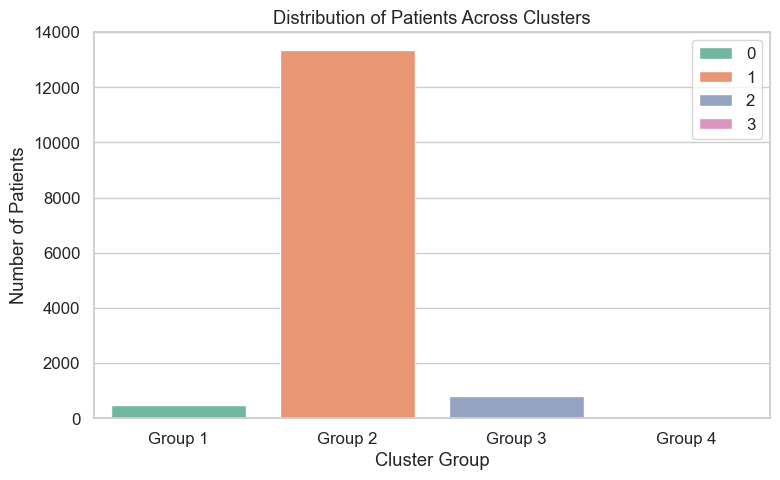

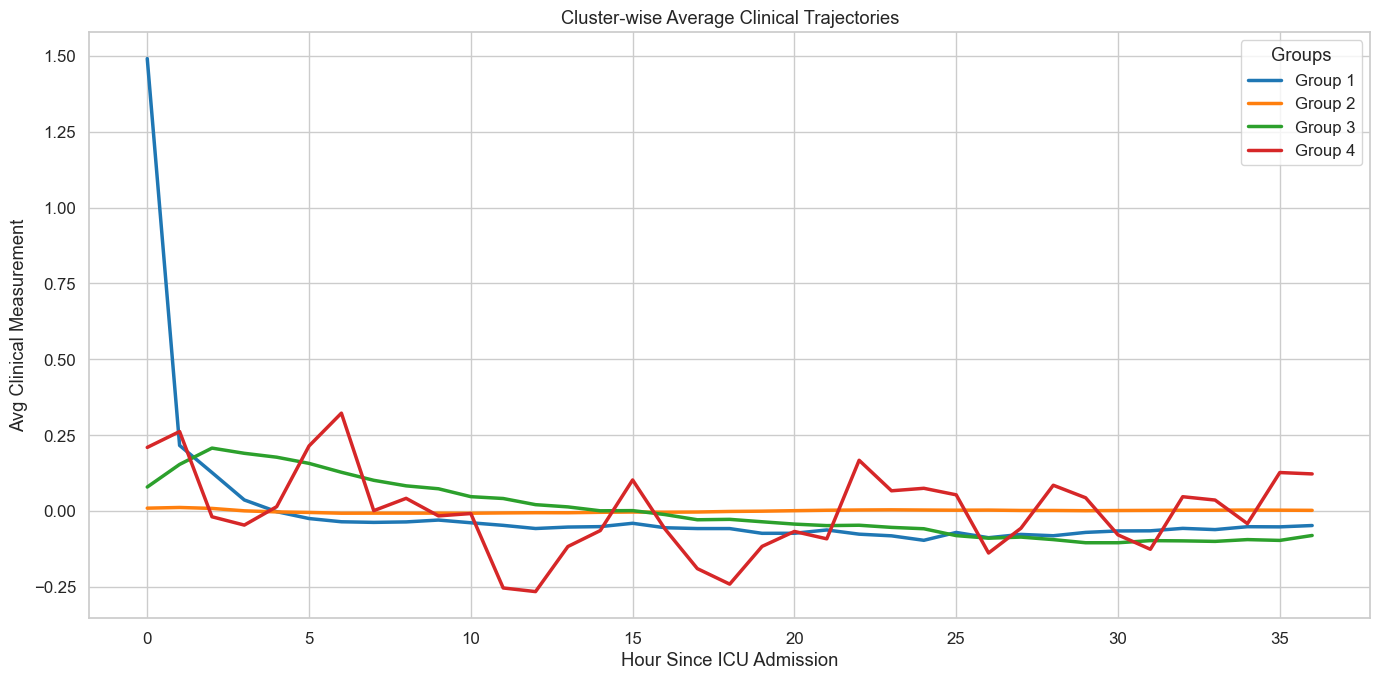

  Cluster Group  Number of Patients
0       Group 1                 488
1       Group 2               13339
2       Group 3                 797
3       Group 4                   1


In [21]:
# ===========================
# Clustering Patient Trajectories (Flattened with PCA)
# ===========================

print("\nClustering patient trajectories...")

# Flatten the imputed tensor: shape -> [num_patients, num_hours * num_features]
X = trajectory_array_imputed.reshape(trajectory_array_imputed.shape[0], -1)

# Optionally, scale X if needed (if you didn't already do per-patient standardization)
scaler_global = StandardScaler()
X_scaled = scaler_global.fit_transform(X)
print(X_scaled.shape)

pca = PCA(n_components=PCA_COMPONENTS)
X_reduced = pca.fit_transform(X_scaled)
print("Explained variance by PCA:", np.sum(pca.explained_variance_ratio_))

# Then proceed with clustering using KMeans
n_clusters = NUM_CLUSTERS
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(X_reduced)

# FIXED: Only define silhouette if valid
if len(set(cluster_labels)) > 1:
    silhouette = silhouette_score(X_reduced, cluster_labels)
    print(" Clustering complete. Silhouette Score:", silhouette)
else:
    silhouette = None  # Prevent undefined variable
    print(" All points assigned to a single cluster. Silhouette score not applicable.")

# Save cluster assignments
cluster_df = pd.DataFrame({'stay_id': model_df['stay_id'].unique(), 'cluster': cluster_labels})
cluster_df.to_csv(os.path.join(DATA_PATH, 'patient_clusters.csv'), index=False)
print("📁 Cluster assignments saved to patient_clusters.csv")

# Compute frequency counts for each cluster label and sort by cluster number
distribution = pd.Series(cluster_labels).value_counts().sort_index()

# Create a DataFrame for a cleaner table format
distribution_df = pd.DataFrame({
    'Cluster Group': [f"Group {i+1}" for i in distribution.index],
    'Number of Patients': distribution.values
})

print(distribution_df)

# Visualization: Cluster Distribution

plt.figure(figsize=(8, 5))
sns.countplot(x=cluster_labels, hue=cluster_labels, palette='Set2')
plt.title("Distribution of Patients Across Clusters")
plt.xlabel("Cluster Group")
plt.ylabel("Number of Patients")
plt.xticks(ticks=range(n_clusters), labels=[f"Group {i+1}" for i in range(n_clusters)])
plt.tight_layout()
plt.show()

# Visualization: Cluster-wise Average Trajectories
plt.figure(figsize=(14, 7))
colors = sns.color_palette("tab10", n_colors=n_clusters)
for cluster_id in range(n_clusters):
    mask = cluster_labels == cluster_id
    if np.sum(mask) == 0:
        continue  # Skip empty cluster
    # Option: use trajectory_array_imputed to ensure no NaNs are present:
    cluster_avg = trajectory_array_imputed[mask].mean(axis=0).mean(axis=1)
    plt.plot(cluster_avg, label=f'Group {cluster_id+1}', linewidth=2.5, color=colors[cluster_id])

plt.title("Cluster-wise Average Clinical Trajectories")
plt.xlabel("Hour Since ICU Admission")
plt.ylabel("Avg Clinical Measurement")
plt.legend(title="Groups")
plt.tight_layout()
plt.show()

# Compute frequency counts for each cluster label and sort by cluster number
distribution = pd.Series(cluster_labels).value_counts().sort_index()

# Create a DataFrame for a cleaner table format
distribution_df = pd.DataFrame({
    'Cluster Group': [f"Group {i+1}" for i in distribution.index],
    'Number of Patients': distribution.values
})

print(distribution_df)

### DEBUG: Verify Mapping Coverage and Missing Fractions

- **Load Source Files:**
  - Load `d_items.csv` and rename the `label` column to `feature`.
  - Load `feature_group_mapping.csv` and `chartevent_top_100_items.csv` into DataFrames.

- **Merge and Verify Top Label Mapping:**
  - Merge `d_items` with `feature_group_mapping` on `feature` (left) and `original_feature` (right) using a left join.
  - Extract top labels from `chartevent_top_100_items.csv` into a list.
  - Filter the merged DataFrame to keep rows where `feature` is in the top labels list.
  - Print a subset of columns (`itemid`, `feature`, `group_rep`) for these mapped top labels.
  - Identify and print any unmapped top labels (rows with missing `group_rep`); otherwise, confirm all top labels are mapped.

- **Check Mapping Coverage in Aggregated DataFrame:**
  - Define high-frequency clinical groups (e.g., 'Safety Measures', 'Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry').
  - From the merged mapping, extract unique `group_rep` names for these high-frequency labels.
  - Loop through each expected clinical group:
    - Check if the group exists as a column in the aggregated DataFrame `df`.
    - If found, compute and print the fraction of missing data; if not, print a warning indicating the group is missing.

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.decomposition import PCA

# # Assuming X_scaled is your scaled data with shape (29296, 1110)
# pca = PCA(n_components=2553)
# pca.fit(X_scaled)

# # Compute the cumulative explained variance
# cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(1, len(cum_exp_var)+1), cum_exp_var, marker='o', linestyle='-')
# plt.xlabel('Number of PCA Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Explained Variance Ratio')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [23]:
# ===========================
# DEBUG: Verify Mapping Coverage and Missing Fractions
# ===========================

# Load source files
d_items = pd.read_csv(os.path.join(DATA_PATH, 'd_items.csv')).rename(columns={'label': 'feature'})
feature_group_mapping = pd.read_csv(os.path.join(DATA_PATH, 'feature_group_mapping.csv'))
top_labels_df = pd.read_csv(os.path.join(DATA_PATH, 'chartevent_top_100_items.csv'))

# Step 1: Merge d_items with group mapping to verify top label coverage
merged_mapping = d_items.merge(feature_group_mapping, left_on='feature', right_on='original_feature', how='left')

top_labels = top_labels_df['Label'].tolist()
mapped_top_labels = merged_mapping[merged_mapping['feature'].isin(top_labels)]

print("\n Mapping Check: Top labels from chartevents")
print(mapped_top_labels[['itemid', 'feature', 'group_rep']])

unmapped = mapped_top_labels[mapped_top_labels['group_rep'].isna()]
if not unmapped.empty:
    print("\n Unmapped labels detected:")
    print(unmapped[['itemid', 'feature']])
else:
    print("\n All top labels are mapped to group_rep")

# Step 2: Check if mapped clinical groups exist in the aggregated DataFrame `df`
print("\n Verifying Missing Fractions for Mapped High-Frequency Groups:")

# Get group_rep names from high-frequency features
high_freq_labels = ['Safety Measures', 'Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry']
expected_groups = merged_mapping[merged_mapping['feature'].isin(high_freq_labels)]['group_rep'].dropna().unique()

for group in expected_groups:
    if group in df.columns:
        frac = df[group].isna().mean()
        print(f" Clinical Group '{group}' found. Missing Fraction: {frac:.4f}")
    else:
        print(f" Clinical Group '{group}' not found in final aggregated DataFrame!")


 Mapping Check: Top labels from chartevents
      itemid                            feature       group_rep
2     220045                         Heart Rate      Heart Rate
5     220048                       Heart Rhythm  Cardiovascular
6     220050   Arterial Blood Pressure systolic     Vital Signs
7     220051  Arterial Blood Pressure diastolic     Vital Signs
8     220052       Arterial Blood Pressure mean     Vital Signs
...      ...                                ...             ...
3583  229381                        Orientation    Neurological
3726  229604                    Therapeutic Bed             NaN
3793  229687             Pain Assessment Method      Pain Scale
3794  229687             Pain Assessment Method      Pain Scale
3919  229858                    Therapeutic Bed             NaN

[110 rows x 3 columns]

 Unmapped labels detected:
      itemid                                            feature
431   223934                                  Dorsal PedPulse R
439   2

___
# Section 7: Contrastive Learning Setup & Model Training
- Defining the contrastive learning dataset (with augmentation) and the encoder model.
- Training the encoder using contrastive loss and tracking training loss.

- **Import Libraries & Print Start Message:**
  - Import PyTorch modules, Dataset/DataLoader, and helper functions.
  - Print a message indicating the start of the contrastive learning pipeline.

- **Step 1: Prepare Tensor Dataset:**
  - Define a custom `PatientContrastiveDataset` class:
    - Stores the input tensor data.
    - Implements `__len__` to return number of patients.
    - Implements `__getitem__` to return a triplet: (anchor, positive, negative):
      - **Anchor:** Original data point.
      - **Positive:** Augmented version of the anchor (via simple Gaussian noise).
      - **Negative:** Randomly selected data point different from the anchor.
  - Convert the numpy trajectory array to a torch tensor (float32) and replace NaNs with zeros.
  - Create an instance of the dataset and a DataLoader with a batch size of 256, shuffling the data.
  - Print the number of patients in the dataset.

- **Step 2: Define Contrastive Model:**
  - Create a simple encoder (`SimpleTrajectoryEncoder`) using a sequential MLP:
    - Flatten input.
    - Linear layer (input_dim to 512) with ReLU activation.
    - Linear layer (512 to hidden_dim, default 128) with Tanh activation for stability.
  - Compute the input dimension from the tensor shape (num_hours × num_features).
  - Instantiate the encoder model and print the input dimension.

- **Step 3: Define Contrastive Loss Function:**
  - Implement `contrastive_loss`:
    - Normalize anchor, positive, and negative embeddings.
    - Compute cosine similarities for anchor-positive and anchor-negative pairs, scaled by a temperature parameter.
    - Compute the loss using a log-sum-exp formulation for numerical stability.
    - Return the mean loss.

In [24]:
# ===========================
# PART : Contrastive Learning Setup & Embedding Generation
# ===========================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random

print("\n🚀 Starting Contrastive Learning Pipeline...")

# ===========================
# Step 1: Prepare Tensor Dataset for Contrastive Learning
# ===========================

class PatientContrastiveDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data

    def __len__(self):
        return self.tensor_data.shape[0]

    def __getitem__(self, idx):
        anchor = self.tensor_data[idx]
        positive = self._augment(anchor)
        negative_idx = random.choice([i for i in range(len(self)) if i != idx])
        negative = self.tensor_data[negative_idx]
        return anchor, positive, negative

    def _augment(self, tensor):
        # Simple Gaussian noise as augmentation
        noise = torch.randn_like(tensor) * 0.05
        return tensor + noise

# Convert numpy array to torch tensor
trajectory_tensor_torch = torch.tensor(trajectory_array, dtype=torch.float32)
trajectory_tensor_torch = torch.nan_to_num(trajectory_tensor_torch, nan=0.0)

dataset = PatientContrastiveDataset(trajectory_tensor_torch)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

print(f"✅ Contrastive Dataset Prepared. Number of Patients: {len(dataset)}")

# ===========================
# Step 2: Define Contrastive Model (Simple CNN or MLP Encoder)
# ===========================

class SimpleTrajectoryEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, hidden_dim),
            # adding stability 
            nn.Tanh()

        )

    def forward(self, x):
        return self.encoder(x)

# Initialize encoder
num_hours = trajectory_tensor_torch.shape[1]
num_features = trajectory_tensor_torch.shape[2]
input_dim = num_hours * num_features
model = SimpleTrajectoryEncoder(input_dim=input_dim).to('cpu')

print("✅ Encoder model initialized. Input dim:", input_dim)

# ===========================
# Step 3: Contrastive Loss Function
# ===========================

import torch.nn.functional as F

def contrastive_loss(anchor, positive, negative, temperature=0.5):
    # Normalize the embeddings
    anchor = F.normalize(anchor, dim=1)
    positive = F.normalize(positive, dim=1)
    negative = F.normalize(negative, dim=1)
    
    # Compute cosine similarities scaled by temperature
    pos_sim = F.cosine_similarity(anchor, positive) / temperature
    neg_sim = F.cosine_similarity(anchor, negative) / temperature
    
    # Use the log-sum-exp trick for numerical stability:
    # Compute loss = -log(exp(pos_sim) / (exp(pos_sim) + exp(neg_sim)))
    # This is equivalent to: loss = -pos_sim + log(exp(pos_sim) + exp(neg_sim))
    loss = -pos_sim + torch.log(torch.exp(pos_sim) + torch.exp(neg_sim) + 1e-8)
    
    return loss.mean()


🚀 Starting Contrastive Learning Pipeline...
✅ Contrastive Dataset Prepared. Number of Patients: 14625
✅ Encoder model initialized. Input dim: 1110


- **Device and Model Setup:**
  - Set device to GPU (if available) or CPU.
  - Move the model to the selected device.
  - Initialize Adam optimizer with a learning rate of 1e-3.
  - (Optional) Learning rate scheduler commented out.
  - Set training for 25 epochs; initialize lists to track loss history.

- **Training Loop:**
  - Set the model to training mode.
  - For each epoch:
    - Initialize epoch and batch loss accumulators.
    - Loop through batches using a tqdm progress bar:
      - Move anchor, positive, and negative samples to the device.
      - Flatten each input to match the model's expected shape.
      - Compute embeddings for anchor, positive, and negative using the model.
      - Calculate the contrastive loss from the embeddings.
      - Zero the gradients, perform backpropagation, and clip gradients (max_norm=1.0).
      - Update model parameters using the optimizer.
      - Accumulate batch loss and store individual batch losses.
    - Compute and record the average loss for the epoch.
    - Print the average loss for the current epoch.

- **Post-Training Loss Analysis:**
  - Define a moving average function (window size = 3).
  - Compute the moving average of the epoch loss history.
  - Plot both the raw epoch loss and its moving average with proper labels, title, legend, and grid.
  - Display the final loss plot.

In [25]:
import torch
import time

# Check MPS availability and set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device being used: {device}")

# Move model to device and verify
model.to(device)
print(f"Model is on: {next(model.parameters()).device}")

###############################
# Simple performance comparison
###############################

tensor_size = 10000
# Test on CPU
torch.device("cpu")
start = time.time()
torch.matmul(torch.randn(tensor_size, tensor_size), torch.randn(tensor_size, tensor_size))
cpu_time = time.time() - start

# Test on MPS if available
if device.type == "mps":
    start = time.time()
    torch.matmul(torch.randn(tensor_size, tensor_size, device=device), 
                 torch.randn(tensor_size, tensor_size, device=device))
    mps_time = time.time() - start
    print(f"Speedup: CPU ({cpu_time:.4f}s) vs MPS ({mps_time:.4f}s) = {cpu_time/mps_time:.2f}x")

Device being used: mps
Model is on: mps:0
Speedup: CPU (2.9260s) vs MPS (0.1690s) = 17.32x


Device being used: mps
Model is on: mps:0


Epoch 1/20: 100%|██████████| 58/58 [00:06<00:00,  9.48it/s]


Epoch 1/20 - Average Loss: 0.2385


Epoch 2/20: 100%|██████████| 58/58 [00:05<00:00, 10.65it/s]


Epoch 2/20 - Average Loss: 0.2221


Epoch 3/20: 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]


Epoch 3/20 - Average Loss: 0.2177


Epoch 4/20: 100%|██████████| 58/58 [00:05<00:00, 10.63it/s]


Epoch 4/20 - Average Loss: 0.2134


Epoch 5/20: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]


Epoch 5/20 - Average Loss: 0.2085


Epoch 6/20: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]


Epoch 6/20 - Average Loss: 0.2062


Epoch 7/20: 100%|██████████| 58/58 [00:05<00:00, 10.65it/s]


Epoch 7/20 - Average Loss: 0.2027


Epoch 8/20: 100%|██████████| 58/58 [00:05<00:00, 10.69it/s]


Epoch 8/20 - Average Loss: 0.2009


Epoch 9/20: 100%|██████████| 58/58 [00:05<00:00, 10.68it/s]


Epoch 9/20 - Average Loss: 0.1951


Epoch 10/20: 100%|██████████| 58/58 [00:05<00:00, 10.66it/s]


Epoch 10/20 - Average Loss: 0.1956


Epoch 11/20: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]


Epoch 11/20 - Average Loss: 0.1966


Epoch 12/20: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]


Epoch 12/20 - Average Loss: 0.1942


Epoch 13/20: 100%|██████████| 58/58 [00:05<00:00, 10.67it/s]


Epoch 13/20 - Average Loss: 0.1966


Epoch 14/20: 100%|██████████| 58/58 [00:05<00:00, 10.71it/s]


Epoch 14/20 - Average Loss: 0.1970


Epoch 15/20: 100%|██████████| 58/58 [00:05<00:00, 10.61it/s]


Epoch 15/20 - Average Loss: 0.1959


Epoch 16/20: 100%|██████████| 58/58 [00:05<00:00, 10.47it/s]


Epoch 16/20 - Average Loss: 0.1947


Epoch 17/20: 100%|██████████| 58/58 [00:05<00:00, 10.51it/s]


Epoch 17/20 - Average Loss: 0.1958


Epoch 18/20: 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]


Epoch 18/20 - Average Loss: 0.1948


Epoch 19/20: 100%|██████████| 58/58 [00:05<00:00, 10.59it/s]


Epoch 19/20 - Average Loss: 0.1936


Epoch 20/20: 100%|██████████| 58/58 [00:05<00:00, 10.45it/s]

Epoch 20/20 - Average Loss: 0.1915


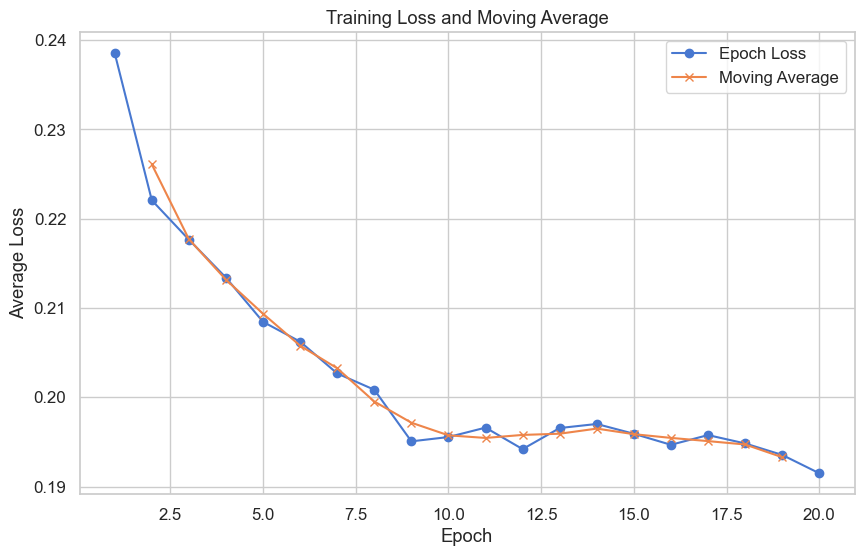

In [26]:
# Check MPS availability and set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device being used: {device}")

# Move model to device and verify
model.to(device)
print(f"Model is on: {next(model.parameters()).device}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Optional: Use a learning rate scheduler:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
epochs = NUM_EPOCHS  # Not too long
loss_history = []
batch_loss_history = []

model.train()  # Set model to training mode

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_losses = []
    
    # Using tqdm to show progress
    for batch_idx, (anchor, positive, negative) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        # Move data to device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        # Flatten inputs if needed (modify this if your model expects a different shape)
        anchor = anchor.view(anchor.shape[0], -1)
        positive = positive.view(positive.shape[0], -1)
        negative = negative.view(negative.shape[0], -1)
        
        # Compute embeddings
        z_anchor = model(anchor)
        z_positive = model(positive)
        z_negative = model(negative)
        
        # Compute contrastive loss
        loss = contrastive_loss(z_anchor, z_positive, z_negative)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Optional: Gradient clipping (e.g., clip gradients to 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
        batch_losses.append(loss.item())
        

    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    batch_loss_history.append(batch_losses)
    
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")

# Define a simple moving average function
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute the moving average of the loss history
loss_moving_avg = moving_average(loss_history, window_size=3)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history)+1), loss_history, label='Epoch Loss', marker='o')
plt.plot(range(2, len(loss_moving_avg)+2), loss_moving_avg, label='Moving Average', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss and Moving Average')
plt.legend()
plt.grid(True)
plt.show()

___
# Section 8: Embedding Generation, Downstream Clustering & Final Results
- Generating embeddings from the trained encoder, running downstream clustering (and t-SNE visualization).
- Saving final embeddings, merging patient-level clusters into the main dataset.

- Print a message indicating the start of embedding generation.
- Set the model to evaluation mode.
- Flatten the trajectory tensor to shape [num_patients, num_hours * num_features] using `reshape`.
- Use `torch.no_grad()` to compute embeddings from the flattened tensor and convert them to a NumPy array.
- Print the shape of the flattened input and check for NaNs in the input.
- Print sample values from the flattened input.
- Print the shape of the generated embeddings and report any NaN rows or total NaNs.
- Print sample embedding values.
- Loop through model parameters to check for any NaNs in the weights and print a warning if found.
- Apply KMeans clustering on the embeddings with a predefined number of clusters (`NUM_CLUSTERS`) and a fixed random state.
- Compute and print the silhouette score to evaluate clustering performance.
- (Optional) Generate an elbow plot:
  - Iterate over k-values from 2 to 10.
  - Fit KMeans for each k and collect inertia values.
  - Plot inertia versus k to visualize the optimal number of clusters.


Generating embeddings using trained encoder...
Input to encoder shape: torch.Size([14625, 1110])
Input NaNs: 0
Input sample:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
Embedding shape: (14625, 128)
🔍 Number of NaN rows: 0
🔍 Total NaNs: 0
🔍 Sample values:
[[-3.1116928e-04  8.2431491e-03 -6.4813817e-04  1.8792908e-03
   1.5794073e-04 -2.7722395e-03 -4.4191615e-03  4.8468108e-03
   3.0278189e-03  2.0036621e-03 -1.2442438e-03  2.3563833e-03
  -2.9874379e-03 -1.3760496e-03 -9.5746585e-04 -2.7809807e-03
  -9.5203926e-05 -5.4927723e-04 -2.3266382e-03  1.9121878e-03
   9.6859649e-04 -1.3147193e-03  2.2303713e-03  1.2671655e-03
   4.4965159e-04 -3.6258016e-02  2.4571123e-03  3.4652788e-03
  -4.2097061e-04 -1.3098795e-03  3.0290596e-03  2.8778834e-03
  -3.5702293e-03 -1.7292927e-03  9.6731895e-04 -2.0367883e-03
   1.3988294e-03 -2.5224241e-03 -1.2325486e-03 -2.0521418e-03
   3.0372969e-03 -1.4560906e-03  4.5995452e-04 -1.1682735e-03
   1.140

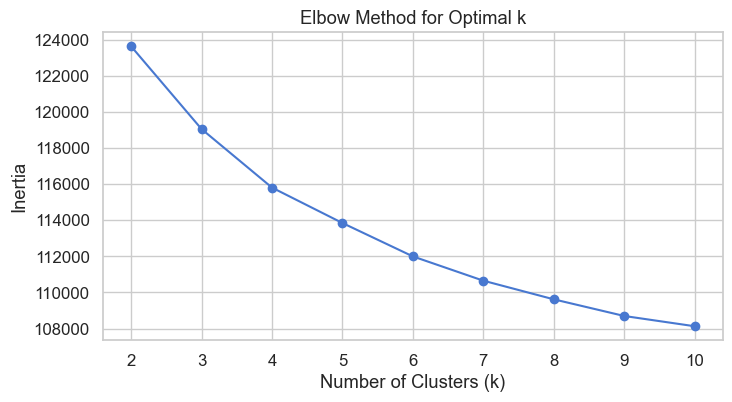

In [27]:
# ===========================
# Step : Generate Embeddings for All Patients
# ===========================

print("\nGenerating embeddings using trained encoder...")
model.eval()

# First ensure model is on MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

# Then move your input tensor to the same device
all_flattened = trajectory_tensor_torch.reshape(trajectory_tensor_torch.shape[0], -1).to(device)

# Now run inference
with torch.no_grad():
    embeddings = model(all_flattened).cpu().numpy()  # Move back to CPU for numpy conversion


print(f"Input to encoder shape: {all_flattened.shape}")
print(f"Input NaNs: {torch.isnan(all_flattened).sum().item()}")
print(f"Input sample:\n{all_flattened[:2]}")

print(f"Embedding shape: {embeddings.shape}")
print(f"🔍 Number of NaN rows: {(np.isnan(embeddings).any(axis=1)).sum()}")
print(f"🔍 Total NaNs: {np.isnan(embeddings).sum()}")
print(f"🔍 Sample values:\n{embeddings[:2]}")

for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"❌ NaNs found in weights of: {name}")

# Apply KMeans clustering with an initial guess for the number of clusters (e.g., k = 5)
k =  NUM_CLUSTERS # You can adjust this based on domain knowledge or prior experimentation
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Compute and print the silhouette score to evaluate clustering performance
sil_score = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score for KMeans with k = {k}: {sil_score:.3f}")

# Optional: Generate an elbow plot to explore a range of cluster numbers
inertias = []
K = range(2, 11)  # Trying k from 2 to 10 clusters
for k_val in K:
    km = KMeans(n_clusters=k_val, random_state=42)
    km.fit(embeddings)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

- **Print Status:**  
  - Print a message indicating t-SNE is running on the learned embeddings.

- **Optional Sampling:**  
  - If the number of embedding rows exceeds 15,000, randomly sample 15,000 rows; otherwise, use all rows.

- **Clean Data:**  
  - Remove any rows with NaN values from the sampled embeddings.
  - Check if there are at least 2 samples; otherwise, skip t-SNE visualization.

- **Adaptive Perplexity:**  
  - Set t-SNE perplexity to the minimum of 30 or (n_samples - 1) to adapt to the sample size.
  - Print the chosen perplexity.

- **Run t-SNE:**  
  - Configure and run t-SNE with 2 components, adaptive perplexity, 1000 iterations, and a fixed random state.
  - Compute the 2D projection of the clean embeddings.

- **Print Summary:**  
  - Print the number of t-SNE samples and the number of cluster labels.

- **Plot t-SNE Projection:**  
  - Create a scatter plot of the t-SNE results using cluster labels (colored by the "viridis" palette).
  - Set the plot title, axis labels, grid, and display the plot.


Running t-SNE on learned embeddings...
🧠 t-SNE Perplexity set to 30 for 14625 samples.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14625 samples in 0.000s...
[t-SNE] Computed neighbors for 14625 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14625
[t-SNE] Computed conditional probabilities for sample 2000 / 14625
[t-SNE] Computed conditional probabilities for sample 3000 / 14625
[t-SNE] Computed conditional probabilities for sample 4000 / 14625
[t-SNE] Computed conditional probabilities for sample 5000 / 14625
[t-SNE] Computed conditional probabilities for sample 6000 / 14625
[t-SNE] Computed conditional probabilities for sample 7000 / 14625
[t-SNE] Computed conditional probabilities for sample 8000 / 14625
[t-SNE] Computed conditional probabilities for sample 9000 / 14625
[t-SNE] Computed conditional probabilities for sample 10000 / 14625
[t-SNE] Computed conditional probabilities for sample 11000 / 14625
[t-SNE] Computed conditional pr

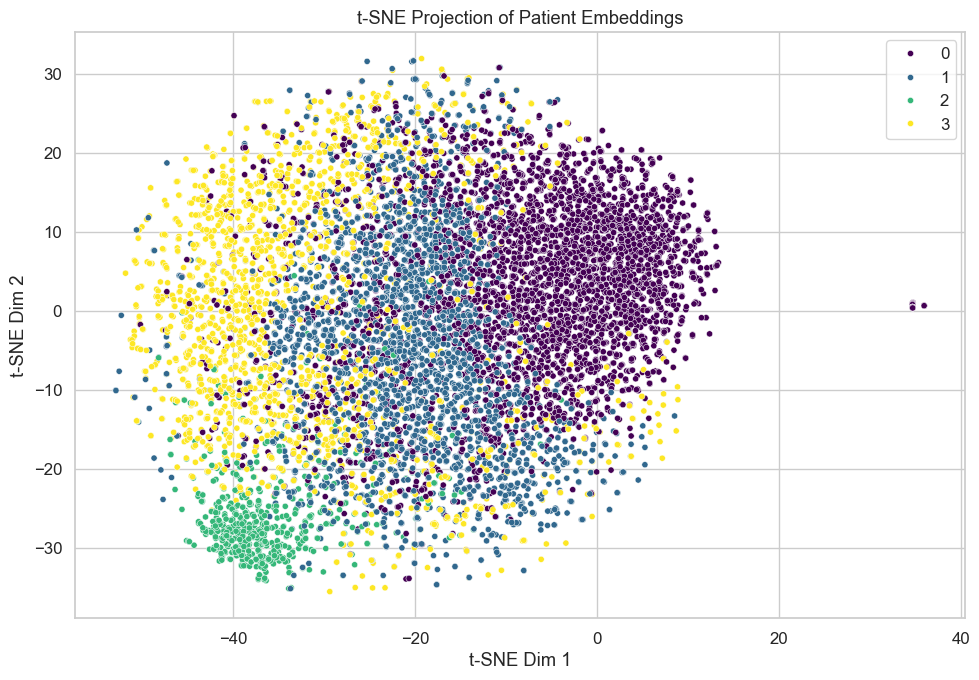

In [28]:
print("Running t-SNE on learned embeddings...")

# 1. Optional sampling if the dataset is too large
max_samples = 30000
num_rows = embeddings.shape[0]

if num_rows > max_samples:
    print(f"⚠️ Dataset has {num_rows} rows; sampling down to {max_samples} for t-SNE.")
    sample_indices = np.random.choice(num_rows, max_samples, replace=False)
    embeddings_sample = embeddings[sample_indices]
else:
    embeddings_sample = embeddings

# 2. Remove rows with any NaNs before t-SNE
clean_embeddings = embeddings_sample[~np.isnan(embeddings_sample).any(axis=1)]
n_samples = clean_embeddings.shape[0]

if n_samples < 2:
    print(f"❌ Not enough samples for t-SNE (only {n_samples}). Skipping visualization.")
else:
    # 3. Optional PCA preprocessing (commented out by default)
    # pca_dim = 50
    # pca = PCA(n_components=pca_dim, random_state=42)
    # embeddings_pca = pca.fit_transform(clean_embeddings)
    
    # 4. Adaptive perplexity based on sample size
    adaptive_perplexity = min(30, n_samples - 1)
    print(f"🧠 t-SNE Perplexity set to {adaptive_perplexity} for {n_samples} samples.")
    
    # 5. Run t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=adaptive_perplexity,
        random_state=42,
        max_iter=1000,  # Increase if needed for more stable results
        verbose=1      # Prints t-SNE progress
    )
    # If using PCA first, replace `clean_embeddings` with `embeddings_pca`
    X_tsne = tsne.fit_transform(clean_embeddings)

print("t-SNE samples:", X_tsne.shape[0])
print("Number of cluster labels:", len(cluster_labels))

# 6. Plot t-SNE
plt.figure(figsize=(10, 7))
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], s=20)

# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette="viridis", s=20)

# If you have labels, you can color-code by cluster or another categorical variable:
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette="viridis", s=20)

plt.title("t-SNE Projection of Patient Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

- Convert the `embeddings` numpy array into a DataFrame and add a `stay_id` column from `model_df`.
- Save the resulting embeddings DataFrame to `contrastive_embeddings.csv`.
- Aggregate the full dataset `df` to one row per patient by grouping on `stay_id` (using the first record per patient) to create `patients_df`.
- Print the number of patients in the aggregated data for verification.
- Assign the cluster labels (from clustering) to `patients_df` and print a sample of the updated DataFrame.
- Merge the patient-level cluster assignments (from `cluster_df`) into the full dataset `df` using a left join on `stay_id` and print the merged DataFrame's shape and a sample.

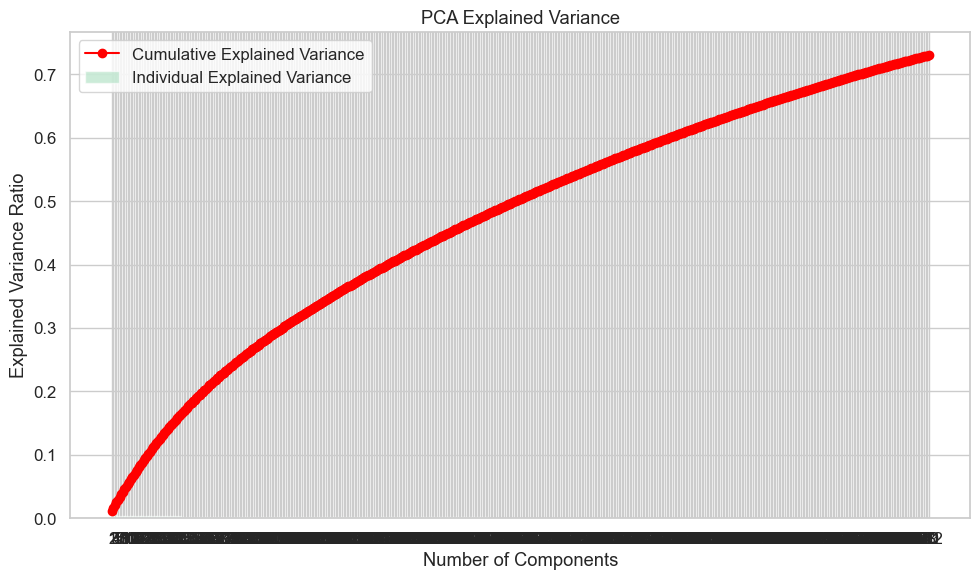

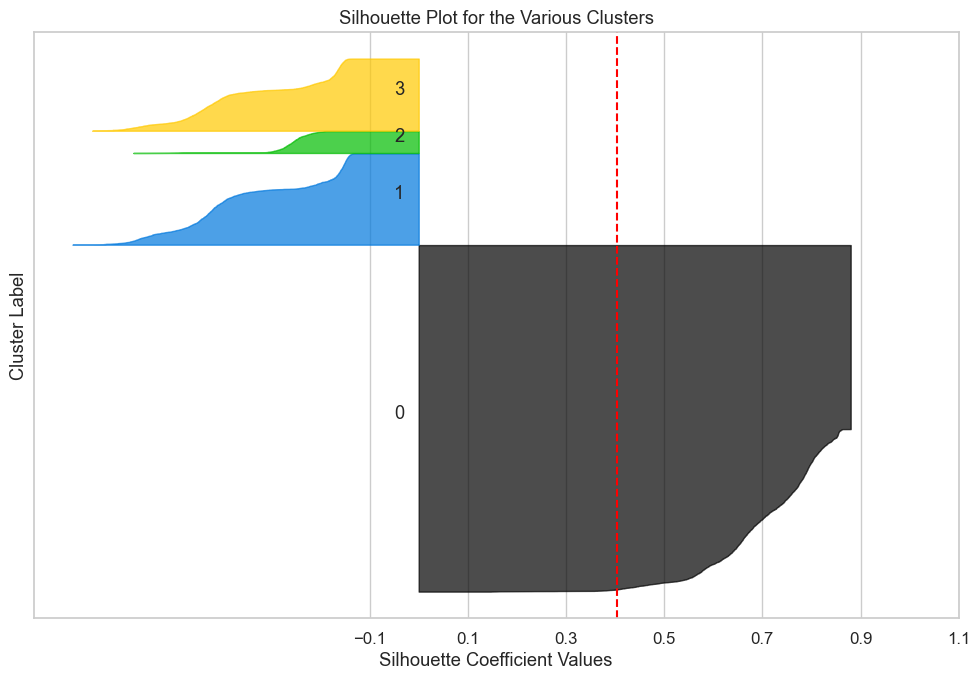

/var/folders/_d/n8tnvsmx4yj860s5ydj8cq_40000gq/T/ipykernel_32628/4253169798.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cluster_labels, palette="Set2")


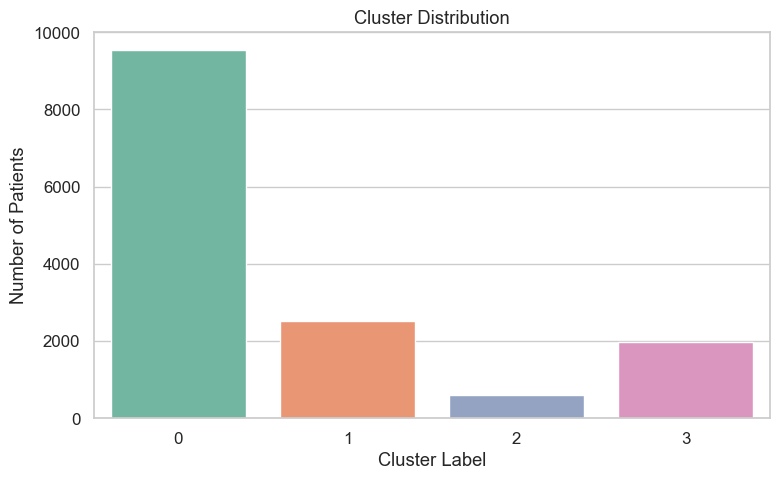

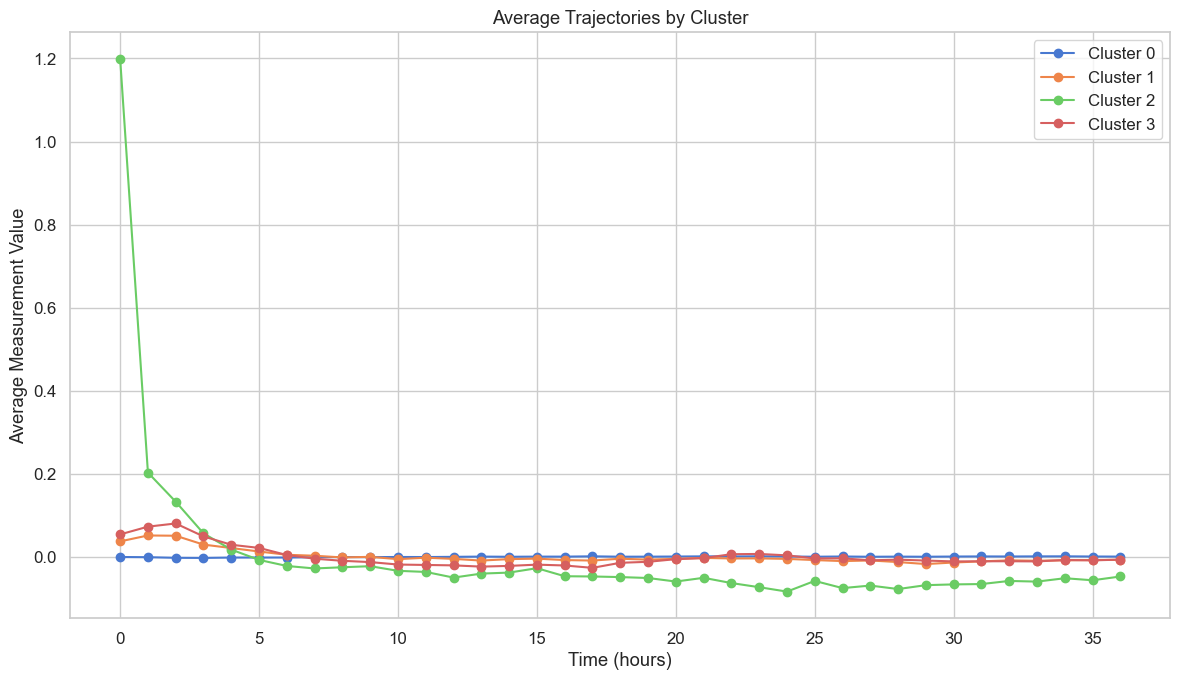

In [29]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

# 1. PCA Explained Variance Plot
def improved_pca_explained_variance_plot(pca, key_components=None):
    """
    Plots individual and cumulative explained variance for PCA components.
    
    Parameters:
    - pca: A fitted PCA object with an explained_variance_ratio_ attribute.
    - key_components: Optional; an integer specifying a key number of components 
                      to highlight with a vertical line.
    """
    # Calculate cumulative explained variance
    cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
    components = np.arange(1, len(cum_exp_var) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Plot individual explained variance as a bar chart
    plt.bar(components, pca.explained_variance_ratio_, alpha=0.6,
            label='Individual Explained Variance', color='#A9DFBF')
    
    # Plot cumulative explained variance as a line plot
    plt.plot(components, cum_exp_var, marker='o', color='red',
             label='Cumulative Explained Variance')
    
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.xticks(components)
    
    # Draw vertical line for key number of components if provided
    if key_components is not None:
        plt.axvline(x=key_components, color='green', linestyle='--', 
                    label=f'{key_components} Components')
        # Annotate the cumulative variance at the key component
        plt.text(key_components + 0.5, cum_exp_var[key_components - 1],
                 f'{cum_exp_var[key_components - 1]:.2f}', color='green')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call this function with  PCA object
improved_pca_explained_variance_plot(pca)

# 2. Silhouette Score Visualization
def plot_silhouette(X, cluster_labels):
    n_clusters = len(np.unique(cluster_labels))
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    fig, ax1 = plt.subplots(figsize=(10, 7))
    y_lower = 10
    for i in range(n_clusters):
        ith_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_silhouette_values.sort()
        size_cluster = ith_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Silhouette Plot for the Various Clusters")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    ax1.set_yticks([])  # Clear the y-axis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
    plt.tight_layout()
    plt.show()

# Call this function with  reduced data
plot_silhouette(X_reduced, cluster_labels)

# 3. Cluster Distribution Chart
def plot_cluster_distribution(cluster_labels):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=cluster_labels, palette="Set2")
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Patients")
    plt.title("Cluster Distribution")
    plt.tight_layout()
    plt.show()

plot_cluster_distribution(cluster_labels)

# 4. Average Trajectories by Cluster
def plot_average_trajectories(trajectory_array, cluster_labels):
    # Average over features for each patient to get a single value per time step
    avg_measurements = np.mean(trajectory_array, axis=2)  # Shape: [num_patients, num_hours]
    
    unique_clusters = np.unique(cluster_labels)
    plt.figure(figsize=(12, 7))
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        if len(indices) == 0:
            continue
        cluster_trajs = avg_measurements[indices, :]
        mean_traj = np.nanmean(cluster_trajs, axis=0)
        plt.plot(mean_traj, marker='o', label=f'Cluster {cluster}')
    plt.xlabel("Time (hours)")
    plt.ylabel("Average Measurement Value")
    plt.title("Average Trajectories by Cluster")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_average_trajectories(trajectory_array_imputed, cluster_labels)


In [30]:
# ===========================
# Step : Save Final Embeddings
# ===========================

embedding_df = pd.DataFrame(embeddings)
embedding_df['stay_id'] = model_df['stay_id'].unique()
embedding_df.to_csv(os.path.join(DATA_PATH, 'contrastive_embeddings.csv'), index=False)
print("✅ Embeddings saved to contrastive_embeddings.csv")

# Aggregate to one row per patient (adjust aggregation as needed)
patients_df = df.groupby('stay_id').first().reset_index()
# Now, patients_df should have the same number of rows as cluster_labels
print("Number of patients in aggregated data:", patients_df.shape[0])  # Should be 3585

# Assign the cluster labels to the aggregated DataFrame
patients_df['cluster'] = cluster_labels
print(patients_df.head())
# Assume cluster_df is the DataFrame you obtained from clustering, with one row per patient:
# For example, cluster_df might look like:
#    stay_id   cluster
# 0  30020739       0
# 1  30020740       1
#  ... (3585 rows in total)

# Merge the patient-level cluster assignments into the full dataset
df_with_clusters = pd.merge(df, cluster_df, on='stay_id', how='left')
print("Merged DataFrame shape:", df_with_clusters.shape)
print(df_with_clusters.head())

✅ Embeddings saved to contrastive_embeddings.csv
Number of patients in aggregated data: 14625
    stay_id           charttime  Assessment  Blood Pressure  Cardiovascular  \
0  30001555 2177-09-27 11:00:00         1.0       92.666667            90.0   
1  30002925 2134-06-05 02:00:00         1.0       81.333333            90.0   
2  30003087 2132-12-01 20:00:00         1.0      115.333333            90.0   
3  30003226 2123-02-26 16:00:00         1.0       81.666667            90.0   
4  30003372 2170-06-10 03:00:00         1.0       86.333333            90.0   

   Critical Care  Dialysis  Discharge Planning  ECMO  Equipment  ...  \
0            0.0       NaN                 NaN   NaN        1.0  ...   
1            0.0       NaN                 0.0   NaN        1.0  ...   
2            1.0       NaN                 1.0   NaN        1.0  ...   
3            0.0       0.0                 NaN   NaN        1.0  ...   
4            NaN       NaN                 NaN   NaN        1.0  ...   